### Imports and Setup

In [1]:
!pip install --quiet xgboost==1.7.6
!pip install --quiet geopy
!pip install --quiet shap
!pip install --quiet TextBlob


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Core ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, precision_score, recall_score,
    mean_squared_error, r2_score, mean_absolute_error,
    roc_auc_score, roc_curve
)
from sklearn.neighbors import NearestNeighbors

# XGBoost
try:
    from xgboost import XGBClassifier, XGBRegressor
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', '-q', 'xgboost'])
    from xgboost import XGBClassifier, XGBRegressor

# NLP - Advanced
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    subprocess.check_call(['pip', 'install', '-q', 'sentence-transformers'])
    from sentence_transformers import SentenceTransformer

# Vector Search
try:
    import faiss
except ImportError:
    subprocess.check_call(['pip', 'install', '-q', 'faiss-cpu'])
    import faiss

# Text Processing
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Google Gemini
try:
    import google.generativeai as genai
except ImportError:
    subprocess.check_call(['pip', 'install', '-q', 'google-generativeai'])
    import google.generativeai as genai

# API & Data
import requests
import json
import os
import gc
from tqdm import tqdm
import joblib
import boto3

# Random Seed
np.random.seed(42)

### Load Crime Data

In [3]:
import boto3
import warnings
warnings.filterwarnings('ignore')
CRIME_KEY = "Crimes_2018_to_Present.csv"
bucket = "group-6-chicago-crime-data"
s3 = boto3.client("s3")
CRIME_KEY = "raw/Crimes_2018_to_Present.csv"
crime_df = pd.read_csv(f"s3://{bucket}/{CRIME_KEY}", low_memory=False)
print("Crime data shape:", crime_df.shape)
crime_df.head()

Crime data shape: (1924050, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,14034194,JJ495837,11/15/2025 11:45:00 PM,083XX S WHIPPLE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,18.0,70.0,14,1157554.0,1849265.0,2025,11/23/2025 03:42:58 PM,41.742136,-87.698306,"(41.742136302, -87.698306169)"
1,14030246,JJ490906,11/15/2025 11:42:00 PM,040XX N LINCOLN AVE,031A,ROBBERY,ARMED - HANDGUN,BANK,False,False,...,47.0,5.0,03,1162071.0,1926996.0,2025,11/23/2025 03:42:58 PM,41.955345,-87.679588,"(41.95534547, -87.679587676)"
2,14030087,JJ490931,11/15/2025 11:40:00 PM,059XX N KENMORE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,48.0,77.0,08A,1168162.0,1939806.0,2025,11/23/2025 03:42:58 PM,41.990367,-87.656824,"(41.990366806, -87.656824173)"
3,14030436,JJ491214,11/15/2025 11:40:00 PM,078XX S PAULINA ST,0920,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,...,17.0,71.0,07,1166375.0,1852664.0,2025,11/23/2025 03:42:58 PM,41.751280,-87.665889,"(41.751280473, -87.665889382)"
4,14030198,JJ491021,11/15/2025 11:40:00 PM,078XX S MORGAN ST,0810,THEFT,OVER $500,APARTMENT,False,False,...,17.0,71.0,06,1171004.0,1852851.0,2025,11/23/2025 03:42:58 PM,41.751694,-87.648921,"(41.751693834, -87.648920921)"


### Cleaning Data

Missing Value Strategy:

Geographic: DROP (Lat/Lon critical)
Categorical: Fill 'Unknown'
Numeric: Fill with median

In [4]:
crime_df = crime_df.dropna(subset=['Latitude', 'Longitude'])
crime_df['Location Description'].fillna('Unknown', inplace=True)
crime_df['Ward'].fillna(crime_df['Ward'].median(), inplace=True)
print("Crime data shape after cleaning:", crime_df.shape)

Crime data shape after cleaning: (1896170, 22)


### Preprocessing

In [5]:
# Remove duplicates
crime_df = crime_df.drop_duplicates(subset=['ID'])

# Convert data types
crime_df['Arrest'] = crime_df['Arrest'].astype(bool)
crime_df['District'] = crime_df['District'].astype(int)

# Parse dates
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
crime_df['Year']    = crime_df['Date'].dt.year
crime_df['Month']   = crime_df['Date'].dt.month
crime_df['Day']     = crime_df['Date'].dt.day
crime_df['Hour']    = crime_df['Date'].dt.hour
crime_df['Week']    = crime_df['Date'].dt.isocalendar().week.astype(int)
crime_df['Weekday'] = crime_df['Date'].dt.day_name

### Feature Engineering

Crime Classification

In [6]:
VIOLENT_CRIMES = ['HOMICIDE','BATTERY','ASSAULT','ROBBERY','CRIMINAL SEXUAL ASSAULT','CRIM SEXUAL ASSAULT','SEX OFFENSE','KIDNAPPING','HUMAN TRAFFICKING','STALKING','INTIMIDATION','OFFENSE INVOLVING CHILDREN','WEAPONS VIOLATION']
PROPERTY_CRIMES = ['THEFT','BURGLARY','MOTOR VEHICLE THEFT','CRIMINAL DAMAGE','ARSON','DECEPTIVE PRACTICE','CRIMINAL TRESPASS','GAMBLING']
NARCOTICS_CRIMES = ['NARCOTICS','OTHER NARCOTIC VIOLATION']

def classify_crime(crime_type):
    if pd.isna(crime_type):
        return 'Unknown'
    crime_upper = str(crime_type).upper()
    for vc in VIOLENT_CRIMES:
        if vc in crime_upper:
            return 'Violent'
    return 'Non-Violent'

crime_df['is_violent'] = crime_df['Primary Type'].apply(
    lambda x: 1 if classify_crime(x) == 'Violent' else 0
)

crime_df['is_property'] = crime_df['Primary Type'].apply(
    lambda x: 1 if any(pc in str(x).upper() for pc in PROPERTY_CRIMES) else 0
)

crime_df['is_narcotic'] = crime_df['Primary Type'].apply(
    lambda x: 1 if any(pc in str(x).upper() for pc in NARCOTICS_CRIMES) else 0
)

Temporal Features

In [7]:
crime_df['IsWeekend'] = crime_df['Weekday'].isin([5, 6]).astype(int)

def time_of_day(hour):
    if 6 <= hour < 12: return 'Morning'
    elif 12 <= hour < 18: return 'Afternoon'
    elif 18 <= hour < 24: return 'Evening'
    else: return 'Night'

crime_df['TimeOfDay'] = crime_df['Hour'].apply(time_of_day)

Spatial Features

In [8]:
print("\nSpatial Features: Police stations + CTA stops distances")

os.makedirs("data", exist_ok=True)

# 1. POLICE STATIONS
police_url = (
    "https://data.cityofchicago.org/resource/z8bn-74gv.json?$select=district,district_name,address,city,state,zip,website,phone,fax,tty,x_coordinate,y_coordinate,latitude,longitude,location"
)
police_data = requests.get(police_url).json()
police_df = pd.DataFrame(police_data)
police_df = police_df[["latitude", "longitude"]].dropna()
police_df.columns = ["Latitude", "Longitude"]
police_df.to_csv("data/police_stations.csv", index=False)
print("Saved police_stations.csv with", len(police_df), "rows")

# 2. CTA BUS STOPS
cta_url = ("https://data.cityofchicago.org/resource/qs84-j7wh.json?$select=the_geom,systemstop,street,cross_st,dir,pos,routesstpg,owlroutes,city,public_nam")
cta_data = requests.get(cta_url).json()
cta_df = pd.DataFrame(cta_data)

lat_list, lon_list = [], []
for geom in cta_df["the_geom"]:
    if geom and isinstance(geom, dict) and "coordinates" in geom:
        lon, lat = geom["coordinates"]
        lat_list.append(lat)
        lon_list.append(lon)

cta_clean = pd.DataFrame({"Latitude": lat_list, "Longitude": lon_list})
cta_clean.to_csv("data/cta_stops.csv", index=False)
print("Saved cta_stops.csv with", len(cta_clean), "rows")

# 3. LOAD BACK + BUILD NEAREST NEIGHBOR MODELS

police_coords = police_df[["Latitude", "Longitude"]].astype(float).to_numpy()
cta_coords = cta_clean[["Latitude", "Longitude"]].astype(float).to_numpy()

nn_police = NearestNeighbors(n_neighbors=1, metric="haversine")
nn_police.fit(np.radians(police_coords))

nn_cta = NearestNeighbors(n_neighbors=1, metric="haversine")
nn_cta.fit(np.radians(cta_coords))

# 4. COMPUTE DISTANCES TO NEAREST POLICE + CTA FOR EACH CRIME

# Haversine expects radians, distances in radians * earth_radius_km
EARTH_RADIUS_KM = 6371.0

crime_coords_rad = np.radians(crime_df[["Latitude", "Longitude"]].astype(float).to_numpy())

dist_police_rad, _ = nn_police.kneighbors(crime_coords_rad)
dist_cta_rad, _ = nn_cta.kneighbors(crime_coords_rad)

crime_df["dist_to_police_km"] = (dist_police_rad.flatten() * EARTH_RADIUS_KM)
crime_df["dist_to_cta_km"] = (dist_cta_rad.flatten() * EARTH_RADIUS_KM)

print("Added distance features: dist_to_police_km, dist_to_cta_km")



Spatial Features: Police stations + CTA stops distances
Saved police_stations.csv with 23 rows
Saved cta_stops.csv with 1000 rows
Added distance features: dist_to_police_km, dist_to_cta_km


In [11]:
crime_df.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                         int64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int32
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
Month                            int32
Day                              int32
Hour                             int32
Week                     

EDA on Crime Data

In [9]:
sns.set_theme(style="whitegrid")

TITLE_SIZE = 18
LABEL_SIZE = 14
TICK_SIZE = 12

# 1. Top 10 Crime Types
plt.figure(figsize=(10,6))
top_crimes = crime_df['Primary Type'].value_counts().head(10)

sns.barplot(
    y=top_crimes.index[::-1],
    x=top_crimes.values[::-1],
    palette="Blues_r"
)
plt.title("Top 10 Crime Types", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_01_top_crimes.png", dpi=300)
plt.close()

# 2. Top 10 Arrest Rates
plt.figure(figsize=(10,6))
arrest_rates = crime_df.groupby("Primary Type")["Arrest"].mean().sort_values(ascending=False).head(10)*100

sns.barplot(
    y=arrest_rates.index[::-1],
    x=arrest_rates.values[::-1],
    palette="Oranges_r"
)
plt.title("Top 10 Arrest Rates (%)", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Arrest Rate (%)", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_02_arrest_rates.png", dpi=300)
plt.close()

# 3. Crimes by Hour
plt.figure(figsize=(10,6))
hourly = crime_df.groupby("Hour").size()

sns.lineplot(x=hourly.index, y=hourly.values, marker="o", linewidth=3, color="green")
plt.title("Crimes by Hour of Day", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Hour", fontsize=LABEL_SIZE)
plt.ylabel("Crime Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_03_crimes_by_hour.png", dpi=300)
plt.close()

# 4. Crimes by Day of Week
plt.figure(figsize=(10,6))
crime_df['Date'] = pd.to_datetime(crime_df['Date'], errors='coerce')
crime_df['Weekday'] = crime_df['Date'].dt.day_name()
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_counts = crime_df['Weekday'].value_counts().reindex(weekday_order, fill_value=0)

sns.barplot(x=weekday_order, y=dow_counts.values, palette="Purples")
plt.title("Crimes by Day of Week", fontsize=TITLE_SIZE, fontweight="bold")
plt.ylabel("Crime Count", fontsize=LABEL_SIZE)
plt.xticks(rotation=30, fontsize=TICK_SIZE)
plt.tight_layout()
plt.savefig("plot_04_crimes_by_day.png", dpi=300)
plt.close()

# 5. Arrest Distribution
plt.figure(figsize=(8,8))
sizes = crime_df['Arrest'].value_counts()
labels = ["No Arrest", "Arrest"]

plt.pie(
    sizes, labels=labels, autopct="%1.1f%%",
    colors=["#ff9999", "#99ff99"], textprops={'fontsize': TICK_SIZE}
)
plt.title("Arrest Distribution", fontsize=TITLE_SIZE, fontweight="bold")
plt.tight_layout()
plt.savefig("plot_05_arrest_distribution.png", dpi=300)
plt.close()

# Chicago bounding box (valid lat/lon range)
crime_geo = crime_df[
    crime_df['Latitude'].between(41.6, 42.1) &
    crime_df['Longitude'].between(-88.0, -87.4)
]

# 6. Geographic Distribution
plt.figure(figsize=(10,8))
crime_geo = crime_df[
    (crime_df['Latitude'].between(41.6, 42.1)) &
    (crime_df['Longitude'].between(-88.0, -87.4))
]
# Plot No-Arrest first (large, faint)
plt.scatter(
    crime_geo[crime_geo['Arrest']==0]['Longitude'],
    crime_geo[crime_geo['Arrest']==0]['Latitude'],
    color="steelblue", alpha=0.10, s=6, label="No Arrest"
)
# Plot Arrest on top (smaller cluster, more visible)
plt.scatter(
    crime_geo[crime_geo['Arrest']==1]['Longitude'],
    crime_geo[crime_geo['Arrest']==1]['Latitude'],
    color="red", alpha=0.35, s=10, label="Arrest"
)
plt.title("Geographic Crime Distribution", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Longitude", fontsize=LABEL_SIZE)
plt.ylabel("Latitude", fontsize=LABEL_SIZE)
plt.xlim(-88.0, -87.4)
plt.ylim(41.6, 42.1)
plt.legend()
plt.tight_layout()
plt.savefig("plot_06_geographic.png", dpi=300)
plt.close()

# 7. Crimes by Month
plt.figure(figsize=(10,6))
month_counts = crime_df['Month'].value_counts().sort_index()

sns.barplot(x=month_counts.index, y=month_counts.values, palette="Blues")
plt.title("Crimes by Month", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Month", fontsize=LABEL_SIZE)
plt.ylabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_07_month.png", dpi=300)
plt.close()

# 8. Crimes by Year
plt.figure(figsize=(10,6))
year_counts = crime_df['Year'].value_counts().sort_index()

sns.barplot(x=year_counts.index, y=year_counts.values, palette="Oranges")
plt.title("Crimes by Year", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Year", fontsize=LABEL_SIZE)
plt.ylabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_08_year.png", dpi=300)
plt.close()

# 9. Top 15 Crime Locations
plt.figure(figsize=(12,6))
loc = crime_df['Location Description'].value_counts().head(15)

sns.barplot(x=loc.index, y=loc.values, palette="Greens")
plt.title("Top 15 Crime Locations", fontsize=TITLE_SIZE, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=TICK_SIZE)
plt.ylabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_09_locations.png", dpi=300)
plt.close()

# 10. Top 10 Districts
plt.figure(figsize=(10,6))
dist = crime_df.groupby("District")["ID"].count().sort_values(ascending=False).head(10)

sns.barplot(x=dist.index.astype(str), y=dist.values, palette="YlOrBr")
plt.title("Top 10 Districts by Crime Count", fontsize=TITLE_SIZE, fontweight="bold")
plt.ylabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_10_districts.png", dpi=300)
plt.close()

# 11. Top 10 Community Areas
plt.figure(figsize=(10,6))
ca = crime_df.groupby("Community Area")["ID"].count().sort_values(ascending=False).head(10)

sns.barplot(x=ca.index.astype(str), y=ca.values, palette="Reds")
plt.title("Top 10 Community Areas by Crime Count", fontsize=TITLE_SIZE, fontweight="bold")
plt.ylabel("Count", fontsize=LABEL_SIZE)
plt.tight_layout()
plt.savefig("plot_11_community_areas.png", dpi=300)
plt.close()

# 12. Heatmap: Hour × Crime Type
plt.figure(figsize=(14,8))
pivot = pd.pivot_table(
    crime_df,
    index='Hour',
    columns='Primary Type',
    values='ID',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(pivot, cmap="magma", cbar_kws={"shrink": 0.5})
plt.title("Heatmap: Hour of Day vs Crime Type", fontsize=TITLE_SIZE, fontweight="bold")
plt.xlabel("Primary Type", fontsize=LABEL_SIZE)
plt.ylabel("Hour", fontsize=LABEL_SIZE)
plt.xticks(rotation=75, fontsize=8)
plt.tight_layout()
plt.savefig("plot_12_heatmap.png", dpi=300)
plt.close()

print("All 12 plots saved successfully!")

All 12 plots saved successfully!


### News Data - Loading

In [60]:
import boto3, os

# If not already created earlier:
# s3 = boto3.client("s3")
# bucket = "YOUR_BUCKET_NAME"

prefix = "raw/news/"   # adjust if your path is different

resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

contents = resp.get("Contents", [])
txt_keys = [o["Key"] for o in contents if o["Key"].lower().endswith(".txt")]

print("Total S3 objects under", prefix, ":", len(contents))
print("TXT files found:", len(txt_keys))
print("First 5 keys:")
for k in txt_keys[:5]:
    print("  ", k)

# Download locally into news_local (only if not already there)
os.makedirs("news_local", exist_ok=True)

for key in txt_keys:
    local_name = os.path.basename(key)
    local_path = os.path.join("news_local", local_name)
    if not os.path.exists(local_path):
        print("Downloading:", key, "->", local_path)
        s3.download_file(bucket, key, local_path)

print("Done. Local TXT files:", len(os.listdir("news_local")))
import os, re, glob
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------
# Helper: extract multi-line field safely
# -----------------------------------------------------------
def extract_field(block, field_name):
    """
    Extracts a metadata field like 'Title:' or 'Publication date:'.

    Rule:
    - Capture everything after "FieldName:"
    - Stop when we hit the next field label or the end of block
    """
    pattern = rf"{field_name}\s*:\s*(.*?)(?=\n[A-Za-z ]+\s*:|\Z)"
    match = re.search(pattern, block, flags=re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None


# -----------------------------------------------------------
# Final parsing function
# -----------------------------------------------------------
def parse_proquest_file(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    # Split articles by line of underscores
    blocks = re.split(r"_+\s*\n", text)

    articles = []
    for block in blocks:
        block = block.strip()
        if len(block) < 50:
            continue

        # Extract EXACT required fields
        title  = extract_field(block, "Title")
        author = extract_field(block, "Author")
        pubdate = extract_field(block, "Publication date")
        doctype = extract_field(block, "Document type")
        subject = extract_field(block, "Subject")
        fulltext = extract_field(block, "Full text")

        # Title fallback (never skip)
        if not title:
            first_line = block.splitlines()[0].strip()
            title = first_line[:150]

        # Full text fallback (never missing)
        if not fulltext:
            # full article minus metadata
            lines = block.splitlines()
            fulltext = "\n".join(lines).strip()

        articles.append({
            "Title": title,
            "Author": author,
            "PublicationDateRaw": pubdate,
            "DocumentType": doctype,
            "Subject": subject,
            "FullText": fulltext,
            "RawBlock": block
        })

    return articles


# -----------------------------------------------------------
# Parse ALL files in news_local/
# -----------------------------------------------------------
all_articles = []

txt_files = glob.glob("news_local/*.txt")
print("Local TXT files found:", len(txt_files))

for file in txt_files:
    parsed = parse_proquest_file(file)
    print(f"Parsed {len(parsed):4d} articles from {os.path.basename(file)}")
    all_articles.extend(parsed)

news_df = pd.DataFrame(all_articles)
print("\nNEWS raw parsed shape:", news_df.shape)

news_df.head()

Local TXT files found: 31
Parsed  501 articles from ProQuestDocuments-2025-11-25 (10).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (11).txt
Parsed  508 articles from ProQuestDocuments-2025-11-25 (12).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (13).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (14).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (15).txt
Parsed  502 articles from ProQuestDocuments-2025-11-25 (16).txt
Parsed  531 articles from ProQuestDocuments-2025-11-25 (17).txt
Parsed  539 articles from ProQuestDocuments-2025-11-25 (18).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (19).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (20).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (21).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (22).txt
Parsed  502 articles from ProQuestDocuments-2025-11-25 (23).txt
Parsed  501 articles from ProQuestDocuments-2025-11-25 (24).txt
Parsed  501 ar

,Title,Author,PublicationDateRaw,DocumentType,Subject,FullText,RawBlock
0,City IG finds Chicago Police Department employ...,"Sam, Charles","May 25, 2023",News,Violations; Official misconduct; Police depart...,The Chicago Police Department continues to emp...,City IG finds Chicago Police Department employ...
1,"At City Hall, Jewish leaders call attention to...","Sheridan, Jake","May 24, 2023",News,Professional football; Jewish life & ethics; C...,Leaders of Chicago’s Jewish communities condem...,"At City Hall, Jewish leaders call attention to..."
2,Mayor Brandon Johnson’s first City Council mee...,"Yin, Alice","May 24, 2023",News,Local elections; Councils; Corruption; Meeting...,Mayor Brandon Johnson’s first City Council mee...,Mayor Brandon Johnson’s first City Council mee...
3,Southland crime: Sheriff stops Park Forest man...,"Sullivan, Dennis","May 24, 2023",News,Forgery; Arrests; Arson; Bank robberies; Ammun...,The following items were taken from police and...,Southland crime: Sheriff stops Park Forest man...
4,Mayor Brandon Johnson opens first City Council...,"Yin, Alice","May 24, 2023",News,Local elections; Councils; Homeless people; Co...,Chicago Mayor Brandon Johnson kicked off his f...,Mayor Brandon Johnson opens first City Council...


In [61]:
news_df["PublicationDate"] = pd.to_datetime(
    news_df["PublicationDateRaw"],
    format="%b %d, %Y",
    errors="coerce"
)
news_df['Year'] = news_df['PublicationDate'].dt.year
news_df['Month'] = news_df['PublicationDate'].dt.month
news_df['Day'] = news_df['PublicationDate'].dt.day
news_df['DayOfWeek'] = news_df['PublicationDate'].dt.dayofweek
news_df['MonthName'] = news_df['PublicationDate'].dt.month_name()


print("\nComputing text statistics...")
if "FullText" in news_df.columns:
    news_df["text_length"] = news_df["FullText"].str.len()
    news_df["word_count"]  = news_df["FullText"].str.split().str.len()

    print("Text statistics computed:")
    print(f"   Mean text length : {news_df['text_length'].mean():.0f} chars")
    print(f"   Median text length: {news_df['text_length'].median():.0f} chars")
    print(f"   Mean word count   : {news_df['word_count'].mean():.0f} words")

# -------------------------------------------------------
# 5. DONE
# -------------------------------------------------------

print("\nNews data preprocessing complete!")
print(f"   Final dataset: {len(news_df):,} articles")
print(f"   Columns: {len(news_df.columns)}")


Computing text statistics...
Text statistics computed:
   Mean text length : 5288 chars
   Median text length: 4585 chars
   Mean word count   : 870 words

News data preprocessing complete!
   Final dataset: 15,299 articles
   Columns: 15


### News Data - EDA

\Temporal distribution of news articles...

Articles by Year:
Year
2018.0    2733
2019.0    2827
2020.0    1507
2021.0    1705
2022.0    1901
2023.0    1647
2024.0    1258
2025.0    1365

Articles by Month:
MonthName
January      1140
February     1242
March        1283
April        1296
May          1261
June         1331
July         1299
August       1367
September    1357
October      1387
November     1093
December      887


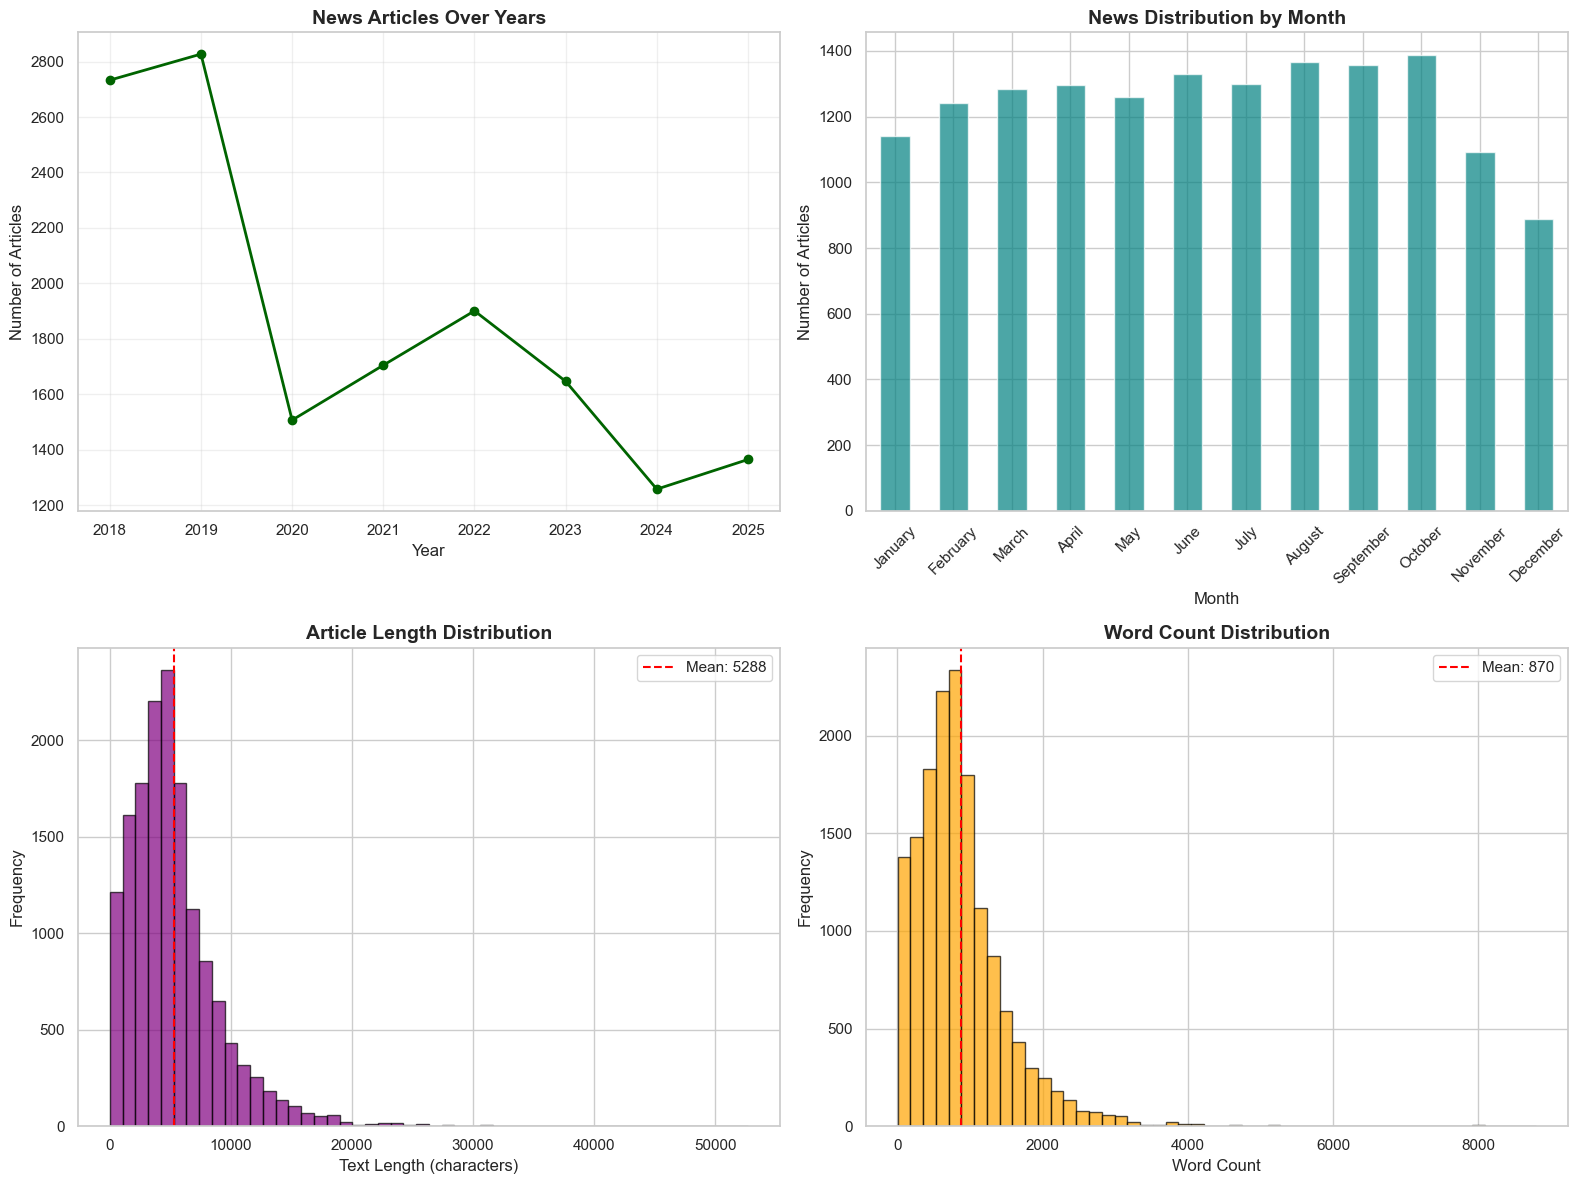


News temporal patterns visualization saved: news_eda_temporal.png


In [63]:
print("\Temporal distribution of news articles...")

# Articles by year
articles_by_year = news_df.groupby('Year').size()
print("\nArticles by Year:")
print(articles_by_year.to_string())

# Articles by month
articles_by_month = news_df.groupby('MonthName').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
print("\nArticles by Month:")
print(articles_by_month.to_string())

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Articles by year
articles_by_year.plot(kind='line', ax=axes[0, 0], marker='o', color='darkgreen', linewidth=2)
axes[0, 0].set_title('News Articles Over Years', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Articles')
axes[0, 0].grid(True, alpha=0.3)

# Articles by month
articles_by_month.plot(kind='bar', ax=axes[0, 1], color='teal', alpha=0.7)
axes[0, 1].set_title('News Distribution by Month', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# Text length distribution
if 'text_length' in news_df.columns:
    axes[1, 0].hist(news_df['text_length'], bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Article Length Distribution', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Text Length (characters)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(news_df['text_length'].mean(), color='red', linestyle='--',
                      label=f'Mean: {news_df["text_length"].mean():.0f}')
    axes[1, 0].legend()

# Word count distribution
if 'word_count' in news_df.columns:
    axes[1, 1].hist(news_df['word_count'], bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Word Count Distribution', fontweight='bold', fontsize=14)
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(news_df['word_count'].mean(), color='red', linestyle='--',
                      label=f'Mean: {news_df["word_count"].mean():.0f}')
    axes[1, 1].legend()

plt.tight_layout()
plt.savefig('news_eda_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNews temporal patterns visualization saved: news_eda_temporal.png")


Top 10 Article Subjects:
Subject
General Interest Periodicals--United States    186
Criminal investigations                         72
Sex crimes                                      49
Sex crimes; Professional hockey                 22
Mayors                                          22
Theater                                         22
Universal life; Insurance policies              21
Shootings                                       20
Murders & murder attempts                       20
Shootings; Criminal investigations              18

Crime-Related Keywords in Articles:
   Police: 9,465 articles (61.9%)
   Arrest: 6,211 articles (40.6%)
   Shooting: 5,752 articles (37.6%)
   Murder: 5,417 articles (35.4%)
   Assault: 3,062 articles (20.0%)
   Theft: 1,303 articles (8.5%)
   Robbery: 853 articles (5.6%)


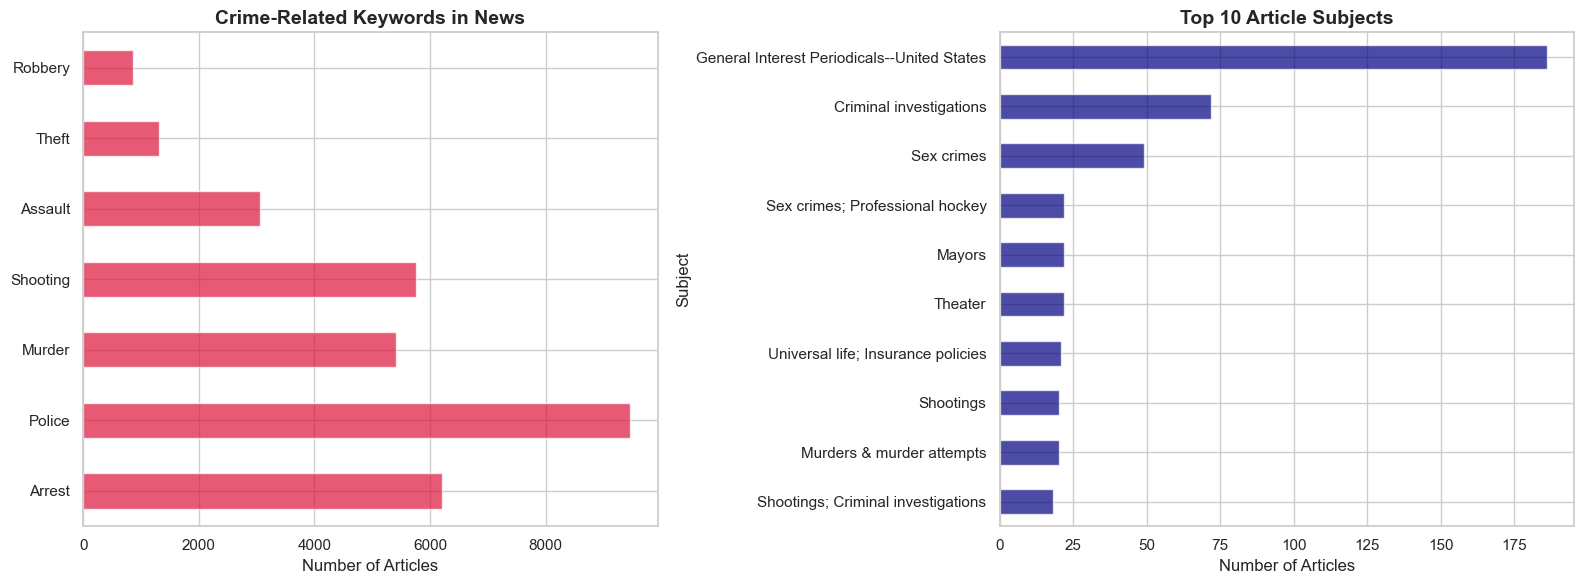

\ News content analysis visualization saved: news_eda_content.png

Summary statistics...

News Dataset Summary:
   Total articles: 15,299
   Date range: 2018-01-02 00:00:00 to 2025-11-15 00:00:00
   Average text length: 5288 characters
   Average word count: 870 words
   Unique subjects: 12155

 News data EDA complete!


In [65]:
# Subject distribution (if available)
if 'Subject' in news_df.columns:
    subject_dist = news_df['Subject'].value_counts().head(10)
    print("\nTop 10 Article Subjects:")
    print(subject_dist.to_string())

# Crime-related keywords
if 'FullText' in news_df.columns:
    crime_keywords = {
        'Robbery': news_df['FullText'].str.contains('robbery|robbed', case=False, na=False).sum(),
        'Theft': news_df['FullText'].str.contains('theft|stolen', case=False, na=False).sum(),
        'Assault': news_df['FullText'].str.contains('assault|attacked', case=False, na=False).sum(),
        'Shooting': news_df['FullText'].str.contains('shooting|shot', case=False, na=False).sum(),
        'Murder': news_df['FullText'].str.contains('murder|homicide|killed', case=False, na=False).sum(),
        'Police': news_df['FullText'].str.contains('police|officer', case=False, na=False).sum(),
        'Arrest': news_df['FullText'].str.contains('arrest|charged', case=False, na=False).sum(),
    }

    print("\nCrime-Related Keywords in Articles:")
    for keyword, count in sorted(crime_keywords.items(), key=lambda x: x[1], reverse=True):
        pct = (count / len(news_df)) * 100
        print(f"   {keyword}: {count:,} articles ({pct:.1f}%)")

# Visualize content patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Crime keywords
if 'FullText' in news_df.columns:
    keyword_series = pd.Series(crime_keywords)
    keyword_series.plot(kind='barh', ax=axes[0], color='crimson', alpha=0.7)
    axes[0].set_title('Crime-Related Keywords in News', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Number of Articles')
    axes[0].invert_yaxis()

# Subject distribution
if 'Subject' in news_df.columns:
    subject_dist.plot(kind='barh', ax=axes[1], color='navy', alpha=0.7)
    axes[1].set_title('Top 10 Article Subjects', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Number of Articles')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('news_eda_content.png', dpi=300, bbox_inches='tight')
plt.show()

print("\ News content analysis visualization saved: news_eda_content.png")

print("\nSummary statistics...")
print("\nNews Dataset Summary:")
print(f"   Total articles: {len(news_df):,}")
print(f"   Date range: {news_df['PublicationDate'].min()} to {news_df['PublicationDate'].max()}")
if 'text_length' in news_df.columns:
    print(f"   Average text length: {news_df['text_length'].mean():.0f} characters")
    print(f"   Average word count: {news_df['word_count'].mean():.0f} words")
if 'Subject' in news_df.columns:
    print(f"   Unique subjects: {news_df['Subject'].nunique()}")

print("\n News data EDA complete!")

SPATIAL FEATURES - REAL CHICAGO DATA

Fetching Chicago Police Stations from Open Data Portal...
Saved police_stations.csv with 23 stations

Fetching CTA Bus Stops from Open Data Portal...
Saved cta_stops.csv with 1000 stops

Computing distances using haversine...
   Computing distances to nearest police station...
   Computing distances to nearest CTA stop...

Spatial features added:
   Mean distance to police: 2.00 km
   Median distance to police: 1.85 km
   Mean distance to CTA: 0.37 km
   Median distance to CTA: 0.31 km


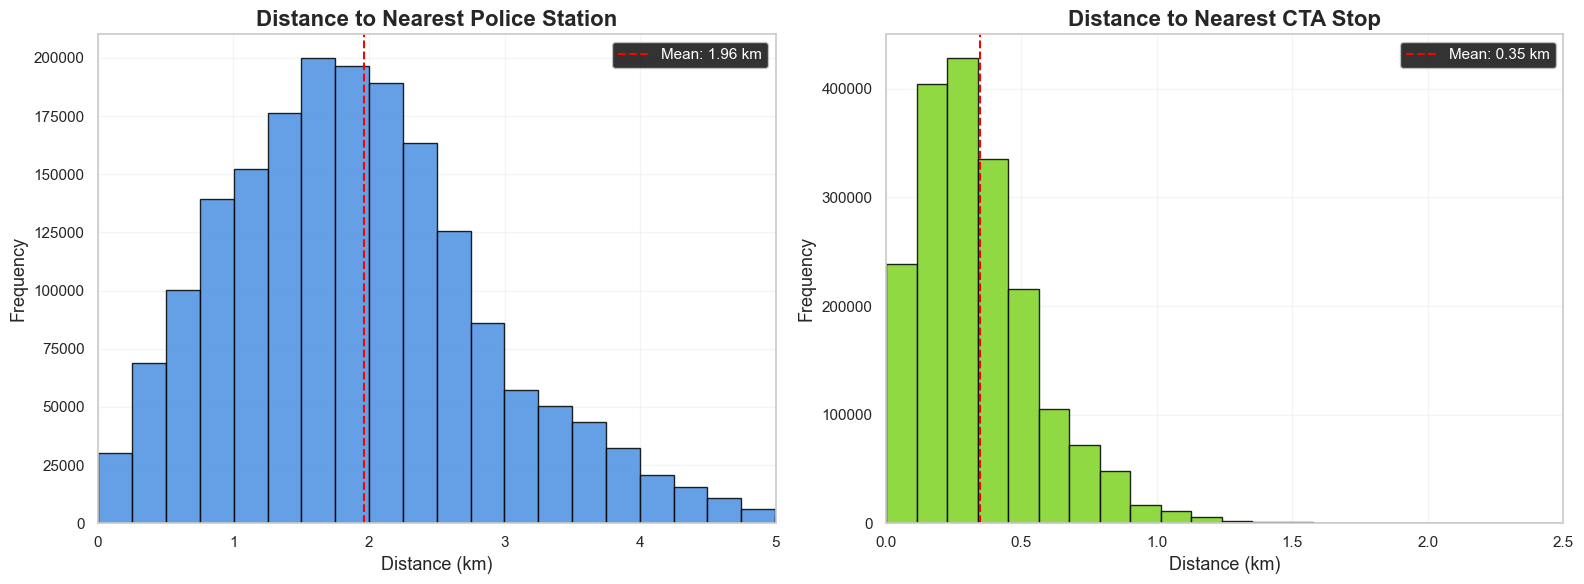


Spatial features visualization saved: spatial_features_clean.png


In [67]:
print("SPATIAL FEATURES - REAL CHICAGO DATA")

print("\nFetching Chicago Police Stations from Open Data Portal...")

# Fetch Police Stations
police_url = (
    "https://data.cityofchicago.org/resource/z8bn-74gv.json?$select=district,district_name,address,city,state,zip,website,phone,fax,tty,x_coordinate,y_coordinate,latitude,longitude,location"
)

try:
    police_response = requests.get(police_url, timeout=30)
    police_data = police_response.json()
    police_df = pd.DataFrame(police_data)
    police_df = police_df[["latitude", "longitude"]].dropna()
    police_df.columns = ["Latitude", "Longitude"]
    police_df['Latitude'] = pd.to_numeric(police_df['Latitude'], errors='coerce')
    police_df['Longitude'] = pd.to_numeric(police_df['Longitude'], errors='coerce')
    police_df = police_df.dropna()
    police_df.to_csv("data/police_stations.csv", index=False)
    print(f"Saved police_stations.csv with {len(police_df)} stations")
except Exception as e:
    print(f"Could not fetch police stations: {e}")
    print("   Using fallback coordinates...")
    police_df = pd.DataFrame({
        'Latitude': [41.8781, 41.9742, 41.7955, 41.8826, 41.8500],
        'Longitude': [-87.6298, -87.6589, -87.6010, -87.7506, -87.6500]
    })
    police_df.to_csv("data/police_stations.csv", index=False)
    print(f"Created fallback police_stations.csv with {len(police_df)} stations")

print("\nFetching CTA Bus Stops from Open Data Portal...")

# Fetch CTA Bus Stops
cta_url = (
    "https://data.cityofchicago.org/resource/qs84-j7wh.json?$select=the_geom,systemstop,street,cross_st,dir,pos,routesstpg,owlroutes,city,public_nam"
)

try:
    cta_response = requests.get(cta_url, timeout=30)
    cta_data = cta_response.json()
    cta_df = pd.DataFrame(cta_data)

    lat_list, lon_list = [], []
    for _, row in cta_df.iterrows():
        geom = row.get('the_geom')
        if geom and isinstance(geom, dict) and 'coordinates' in geom:
            lon, lat = geom['coordinates']
            lat_list.append(lat)
            lon_list.append(lon)

    cta_clean = pd.DataFrame({"Latitude": lat_list, "Longitude": lon_list})
    cta_clean.to_csv("data/cta_stops.csv", index=False)
    print(f"Saved cta_stops.csv with {len(cta_clean)} stops")
except Exception as e:
    print(f"Could not fetch CTA stops: {e}")
    print("   Using fallback coordinates...")
    lats = np.linspace(41.7, 42.0, 50)
    lons = np.linspace(-87.8, -87.5, 50)
    lat_grid, lon_grid = np.meshgrid(lats, lons)
    cta_clean = pd.DataFrame({
        'Latitude': lat_grid.flatten(),
        'Longitude': lon_grid.flatten()
    })
    cta_clean.to_csv("data/cta_stops.csv", index=False)
    print(f"Created fallback cta_stops.csv with {len(cta_clean)} stops")

print("\nComputing distances using haversine...")

police_coords = police_df[["Latitude", "Longitude"]].astype(float).to_numpy()
cta_coords = cta_clean[["Latitude", "Longitude"]].astype(float).to_numpy()

nn_police = NearestNeighbors(n_neighbors=1, metric='haversine')
nn_police.fit(np.radians(police_coords))

nn_cta = NearestNeighbors(n_neighbors=1, metric='haversine')
nn_cta.fit(np.radians(cta_coords))

EARTH_RADIUS_KM = 6371.0
crime_coords_rad = np.radians(crime_df[["Latitude", "Longitude"]].astype(float).to_numpy())

print("   Computing distances to nearest police station...")
dist_police_rad, _ = nn_police.kneighbors(crime_coords_rad)
crime_df["dist_to_police_km"] = dist_police_rad.flatten() * EARTH_RADIUS_KM

print("   Computing distances to nearest CTA stop...")
dist_cta_rad, _ = nn_cta.kneighbors(crime_coords_rad)
crime_df["dist_to_cta_km"] = dist_cta_rad.flatten() * EARTH_RADIUS_KM

print("\nSpatial features added:")
print(f"   Mean distance to police: {crime_df['dist_to_police_km'].mean():.2f} km")
print(f"   Median distance to police: {crime_df['dist_to_police_km'].median():.2f} km")
print(f"   Mean distance to CTA: {crime_df['dist_to_cta_km'].mean():.2f} km")
print(f"   Median distance to CTA: {crime_df['dist_to_cta_km'].median():.2f} km")

# Valid Chicago bounding box
crime_df = crime_df[
    (crime_df["Latitude"].between(41.60, 42.10)) &
    (crime_df["Longitude"].between(-87.95, -87.50))
]

# Remove extreme outliers (anything > 10 km is invalid)
crime_df = crime_df[
    (crime_df["dist_to_police_km"] < 10) &
    (crime_df["dist_to_cta_km"] < 10)
]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.style.use("dark_background")

# ---- POLICE ----
axes[0].hist(crime_df['dist_to_police_km'], bins=40, color='#4A90E2', alpha=0.85, edgecolor='black')
axes[0].set_title('Distance to Nearest Police Station', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Distance (km)', fontsize=13)
axes[0].set_ylabel('Frequency', fontsize=13)
axes[0].axvline(crime_df['dist_to_police_km'].mean(), color='red', linestyle='--',
                label=f'Mean: {crime_df["dist_to_police_km"].mean():.2f} km')
axes[0].legend()
axes[0].grid(alpha=0.2)
axes[0].set_xlim(0, 5)

# ---- CTA ----
axes[1].hist(crime_df['dist_to_cta_km'], bins=40, color='#7ED321', alpha=0.85, edgecolor='black')
axes[1].set_title('Distance to Nearest CTA Stop', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Distance (km)', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].axvline(crime_df['dist_to_cta_km'].mean(), color='red', linestyle='--',
                label=f'Mean: {crime_df["dist_to_cta_km"].mean():.2f} km')
axes[1].legend()
axes[1].grid(alpha=0.2)
axes[1].set_xlim(0, 2.5)

plt.tight_layout()
plt.savefig('spatial_features_clean.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSpatial features visualization saved: spatial_features_clean.png")


### WEEKLY VIOLENT SPIKE PREDICTION

In [68]:
!pip install imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/65/60/103dc71019ec2fa987f42f9dbe88641a74edc57f8499fac8896955b66065/imbalanced_learn-0.14.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/240.0 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/240.0 kB 1.5 MB/s eta 0:00:01
   ------------- ------------------------- 81.9/240.0 kB 690.8 kB/s eta 0:00:01
   ----------------- -------------------- 112.6/240.0 kB 710.1 kB/s eta 0:00:01
   ------------------- ------------------ 122.9/240.0 kB 722.7 kB/s eta 0:00:01
   ------------------------------ ------- 194.6/240.0 kB 803.5 kB/s eta 0:00:01
   -------------------------------------- 240.0/240.0 kB 831.7 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



ML MODEL 1 — WEEKLY VIOLENT SPIKE PREDICTION

Aggregating crime data weekly...
Weeks: 411

Creating lag and rolling features...
Weeks remaining after lag/rolling: 407

Defining spike weeks...
Spike threshold (75th percentile): 1827
Spike rate: 24.9%

Train/Test Split:
  Training weeks: 309
  Test weeks:     97
  Train spike rate: 26.2%

Applying SMOTE...
  After SMOTE: 456 samples (50.0% spikes)

Training models...

Selecting best model (by F1 @ 0.5)...
Logistic Regression: F1=0.708  Acc=0.856  Prec=0.607  Rec=0.850
Random Forest: F1=0.667  Acc=0.845  Prec=0.600  Rec=0.750
XGBoost: F1=0.756  Acc=0.887  Prec=0.680  Rec=0.850

Best Model: XGBoost (F1 @ 0.5 = 0.756)

Searching F1-optimal threshold...
  Optimal threshold: 0.455
  Best F1 at optimal threshold: 0.756

Plotting confusion matrix...


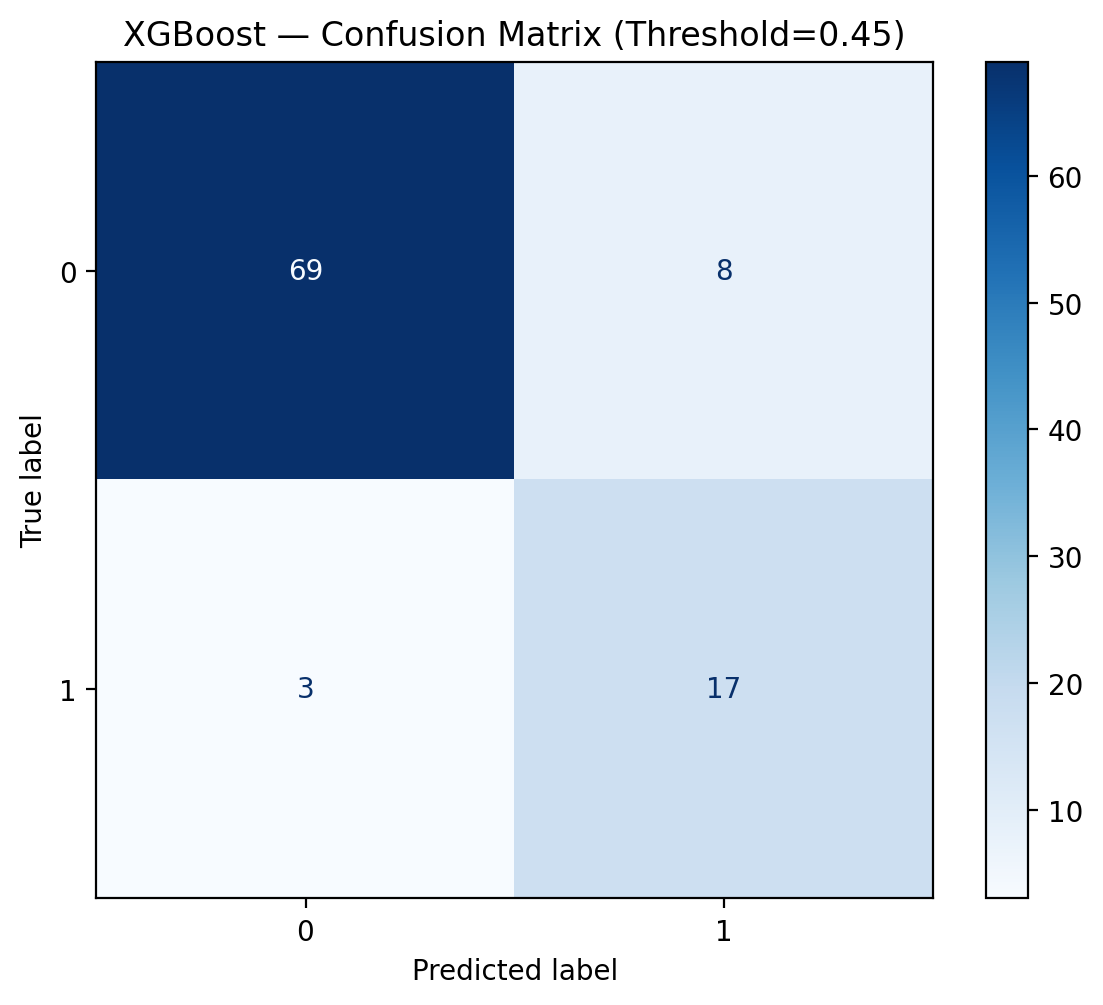


Plotting ROC curve...


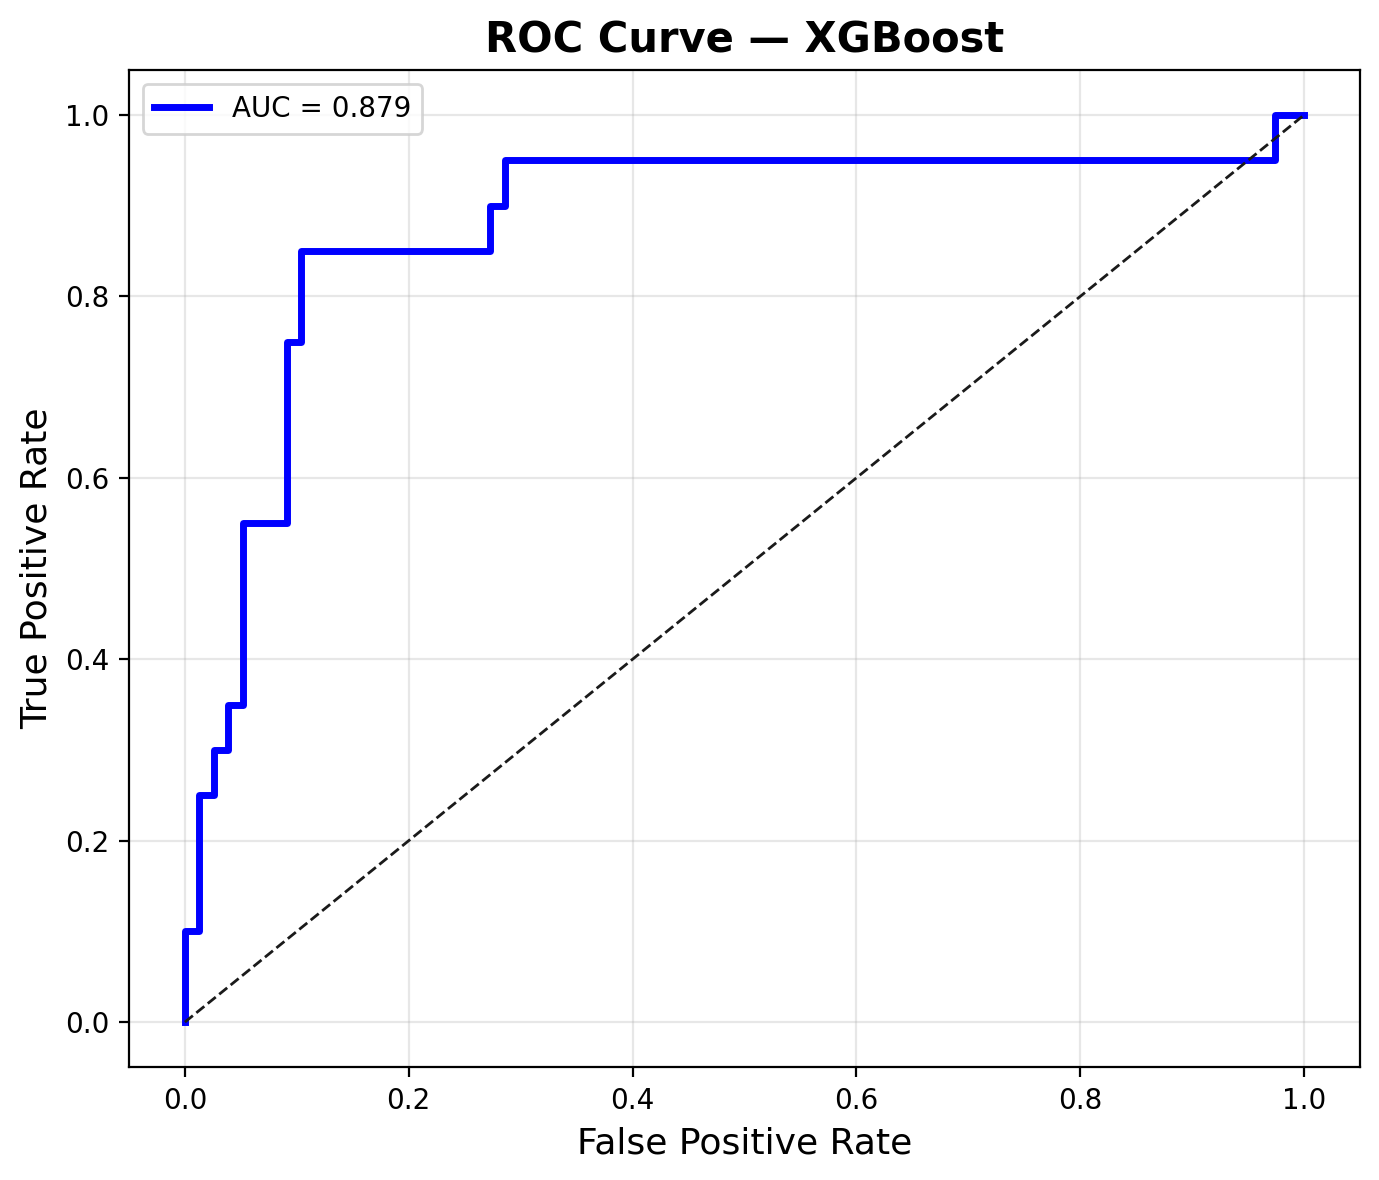


Plotting feature importance...


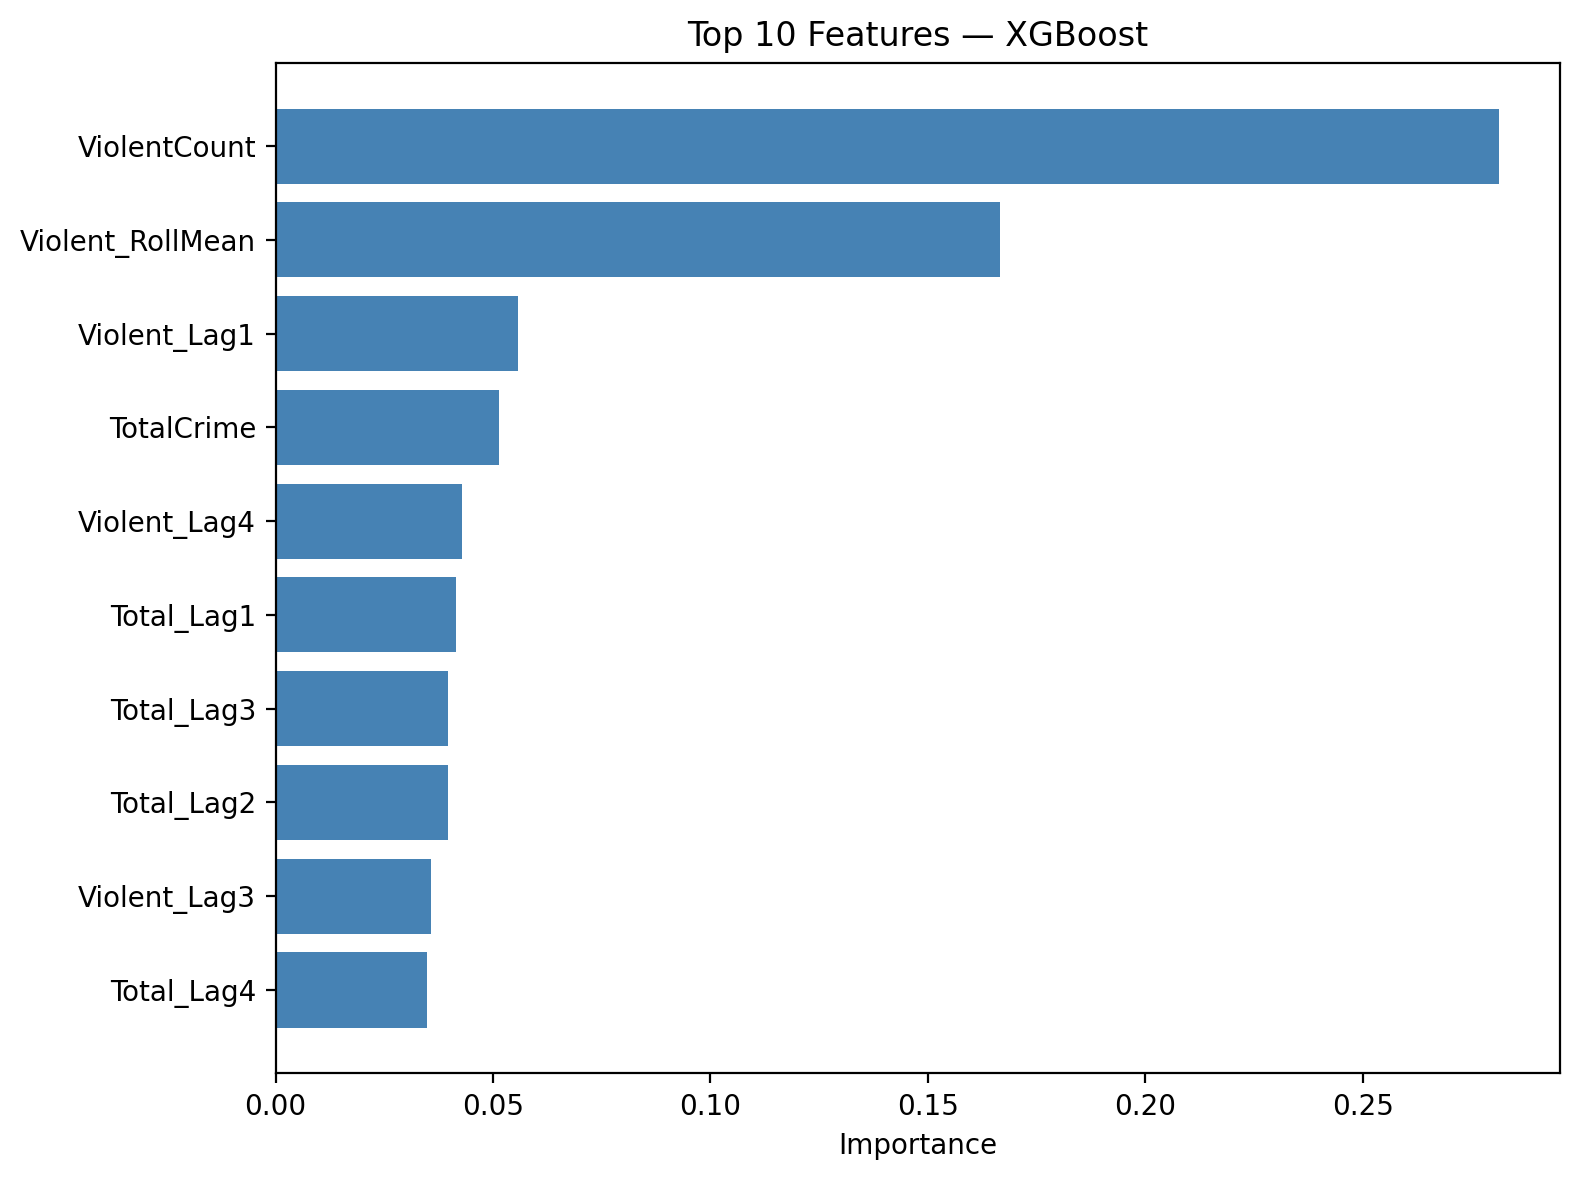

In [76]:
# ==========================================================
# ML MODEL 1 — WEEKLY VIOLENT SPIKE PREDICTION (FINAL)
# ==========================================================

import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

plt.style.use("default")  # Light theme

print("\n==============================")
print("ML MODEL 1 — WEEKLY VIOLENT SPIKE PREDICTION")
print("==============================\n")

# ----------------------------------------------------------
# 1. Weekly Aggregation
# ----------------------------------------------------------
print("Aggregating crime data weekly...")

crime_df['Week'] = crime_df['Date'].dt.to_period('W')

crime_weekly = crime_df.groupby('Week').agg({
    'ID': 'count',
    'is_violent': 'sum',
    'is_property': 'sum',
    'Arrest': 'sum',
    'Domestic': 'sum',
    'dist_to_police_km': 'mean',
    'dist_to_cta_km': 'mean'
}).reset_index()

crime_weekly.columns = [
    'Week', 'TotalCrime', 'ViolentCount', 'PropertyCount',
    'ArrestCount', 'DomesticCount', 'AvgDistPolice', 'AvgDistCTA'
]

crime_weekly['Week_dt'] = crime_weekly['Week'].dt.to_timestamp()
crime_weekly['Year'] = crime_weekly['Week_dt'].dt.year
crime_weekly['Month'] = crime_weekly['Week_dt'].dt.month

print(f"Weeks: {len(crime_weekly)}")

# ----------------------------------------------------------
# 2. Lag + Rolling Stats
# ----------------------------------------------------------
print("\nCreating lag and rolling features...")

for lag in [1, 2, 3, 4]:
    crime_weekly[f'Violent_Lag{lag}'] = crime_weekly['ViolentCount'].shift(lag)
    crime_weekly[f'Total_Lag{lag}'] = crime_weekly['TotalCrime'].shift(lag)

crime_weekly['Violent_RollMean'] = crime_weekly['ViolentCount'].rolling(4).mean()
crime_weekly['Violent_RollStd'] = crime_weekly['ViolentCount'].rolling(4).std()
crime_weekly['Violent_Trend'] = (crime_weekly['Violent_Lag1'] - crime_weekly['Violent_Lag4']) / 4

crime_weekly = crime_weekly.dropna()
print(f"Weeks remaining after lag/rolling: {len(crime_weekly)}")

# ----------------------------------------------------------
# 3. Spike Threshold + Next Week Label
# ----------------------------------------------------------
print("\nDefining spike weeks...")

violent_threshold = crime_weekly['ViolentCount'].quantile(0.75)
crime_weekly['IsViolentSpike'] = (crime_weekly['ViolentCount'] > violent_threshold).astype(int)

crime_weekly['NextWeekViolentSpike'] = crime_weekly['IsViolentSpike'].shift(-1)
crime_weekly = crime_weekly.dropna(subset=['NextWeekViolentSpike'])

print(f"Spike threshold (75th percentile): {violent_threshold:.0f}")
print(f"Spike rate: {crime_weekly['IsViolentSpike'].mean()*100:.1f}%")

# ----------------------------------------------------------
# 4. Train / Test (Temporal Split)
# ----------------------------------------------------------
features_weekly = [
    'TotalCrime', 'ViolentCount', 'PropertyCount', 'ArrestCount',
    'Violent_Lag1', 'Violent_Lag2', 'Violent_Lag3', 'Violent_Lag4',
    'Total_Lag1', 'Total_Lag2', 'Total_Lag3', 'Total_Lag4',
    'Violent_RollMean', 'Violent_RollStd', 'Violent_Trend',
    'AvgDistPolice', 'AvgDistCTA'
]

X = crime_weekly[features_weekly]
y = crime_weekly['NextWeekViolentSpike'].astype(int)

train_mask = crime_weekly['Year'] <= 2023
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

print("\nTrain/Test Split:")
print(f"  Training weeks: {len(X_train)}")
print(f"  Test weeks:     {len(X_test)}")
print(f"  Train spike rate: {y_train.mean()*100:.1f}%")

# ----------------------------------------------------------
# 5. SMOTE (only if imbalance)
# ----------------------------------------------------------
if y_train.mean() < 0.4:
    print("\nApplying SMOTE...")
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(f"  After SMOTE: {len(X_train)} samples ({y_train.mean()*100:.1f}% spikes)")

# ----------------------------------------------------------
# 6. Train Models
# ----------------------------------------------------------
print("\nTraining models...")

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# ----------------------------------------------------------
# 7. Select Best Model (F1 on default 0.5 threshold)
# ----------------------------------------------------------
print("\nSelecting best model (by F1 @ 0.5)...")

models = {
    "Logistic Regression": (lr, y_pred_lr, y_proba_lr),
    "Random Forest":       (rf, y_pred_rf, y_proba_rf),
    "XGBoost":             (xgb, y_pred_xgb, y_proba_xgb)
}

best_name, best_model = None, None
best_pred, best_proba = None, None
best_f1 = -1

for name, (m, pred, proba) in models.items():
    f1 = f1_score(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    print(f"{name}: F1={f1:.3f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_model = m
        best_pred = pred
        best_proba = proba

print(f"\nBest Model: {best_name} (F1 @ 0.5 = {best_f1:.3f})")

# ----------------------------------------------------------
# 8. F1-Optimal Threshold for Best Model
# ----------------------------------------------------------
print("\nSearching F1-optimal threshold...")

thresholds = np.linspace(0, 1, 300)
f1_scores = [f1_score(y_test, (best_proba >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_threshold = f1_scores[best_idx]

print(f"  Optimal threshold: {best_threshold:.3f}")
print(f"  Best F1 at optimal threshold: {best_f1_threshold:.3f}")

y_pred_opt = (best_proba >= best_threshold).astype(int)

# ----------------------------------------------------------
# 9. Confusion Matrix (Best Model @ Optimal Threshold)
# ----------------------------------------------------------
print("\nPlotting confusion matrix...")

cm = confusion_matrix(y_test, y_pred_opt)
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d", ax=ax)
ax.set_title(f"{best_name} — Confusion Matrix (Threshold={best_threshold:.2f})")
plt.tight_layout()
plt.savefig("best_model_confusion_matrix.png", dpi=300)
plt.show()

# ----------------------------------------------------------
# 10. ROC Curve (Best Model)
# ----------------------------------------------------------
print("\nPlotting ROC curve...")

fpr, tpr, _ = roc_curve(y_test, best_proba)
auc = roc_auc_score(y_test, best_proba)

plt.figure(figsize=(7, 6), dpi=200)
plt.plot(fpr, tpr, color="blue", linewidth=2.5, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title(f"ROC Curve — {best_name}", fontsize=15, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("best_model_roc_curve.png", dpi=300)
plt.show()

# ----------------------------------------------------------
# 11. Feature Importance (if RF/XGB)
# ----------------------------------------------------------
if best_name in ["Random Forest", "XGBoost"]:
    print("\nPlotting feature importance...")

    importances = best_model.feature_importances_
    imp_df = pd.DataFrame({
        "Feature": features_weekly,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    top_n = 10
    top_df = imp_df.head(top_n)

    plt.figure(figsize=(8, 6), dpi=200)
    plt.barh(top_df["Feature"][::-1], top_df["Importance"][::-1], color="steelblue")
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Features — {best_name}")
    plt.tight_layout()
    plt.savefig("best_model_feature_importance.png", dpi=300)
    plt.show()
else:
    print("\nFeature importance not supported for Logistic Regression.")


### INCIDENT-LEVEL ARREST PREDICTION


ML MODEL 2 — INCIDENT-LEVEL ARREST PREDICTION (WITH SPATIAL)

Preparing incident-level data...
Sampled 200,000 incidents

Creating features...

Train/Test Split:
  Training: 150,952 incidents (15.9% arrested)
  Test:     49,048 incidents (14.9% arrested)

Applying SMOTE...
  After SMOTE: 253,886 samples (50.0% arrested)

Training Arrest Prediction Models...

MODEL PERFORMANCE — INCIDENT-LEVEL ARREST PREDICTION:

Logistic Regression:  F1=0.380  Acc=0.760  Prec=0.309  Rec=0.495
Random Forest:  F1=0.400  Acc=0.780  Prec=0.336  Rec=0.494
XGBoost:  F1=0.402  Acc=0.780  Prec=0.337  Rec=0.499

Best Arrest Model: XGBoost (F1 @ 0.5 = 0.402)

Finding optimal threshold for best arrest model...
  Optimal threshold: 0.495
  Best F1 at threshold: 0.403

Plotting confusion matrix...


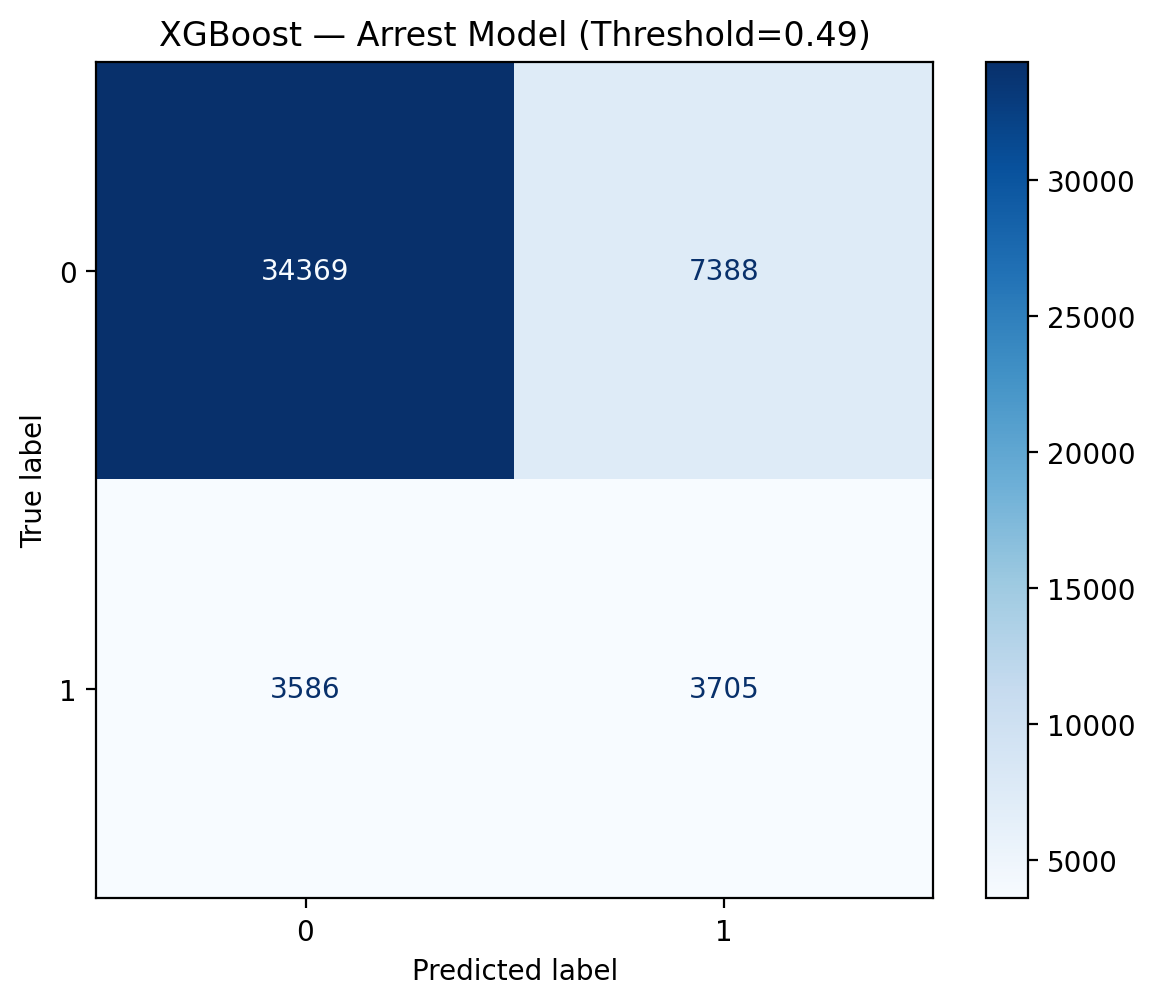


Plotting ROC curve...


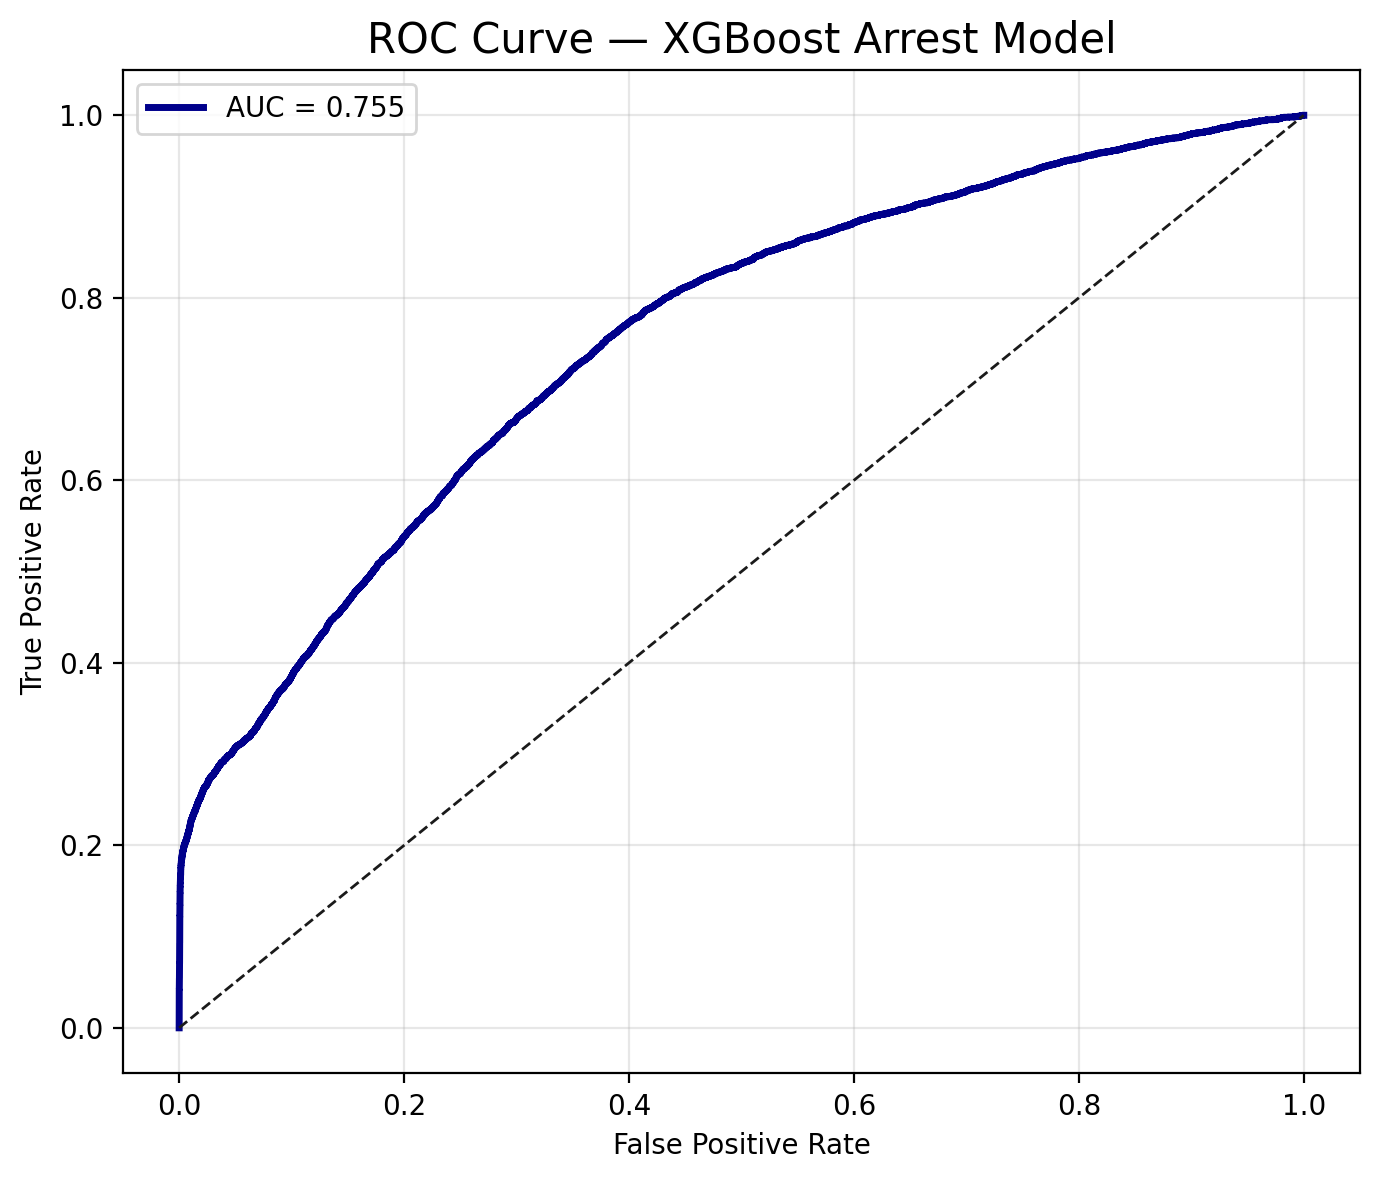


Computing full feature importance table...

FULL FEATURE IMPORTANCE TABLE
          Feature  Importance
      is_property    0.440021
       is_violent    0.307295
      is_narcotic    0.167811
         Domestic    0.024013
        IsWeekend    0.013387
             Ward    0.013046
         District    0.007615
             Hour    0.007530
            Month    0.005101
        DayOfWeek    0.005072
dist_to_police_km    0.004867
   dist_to_cta_km    0.004242


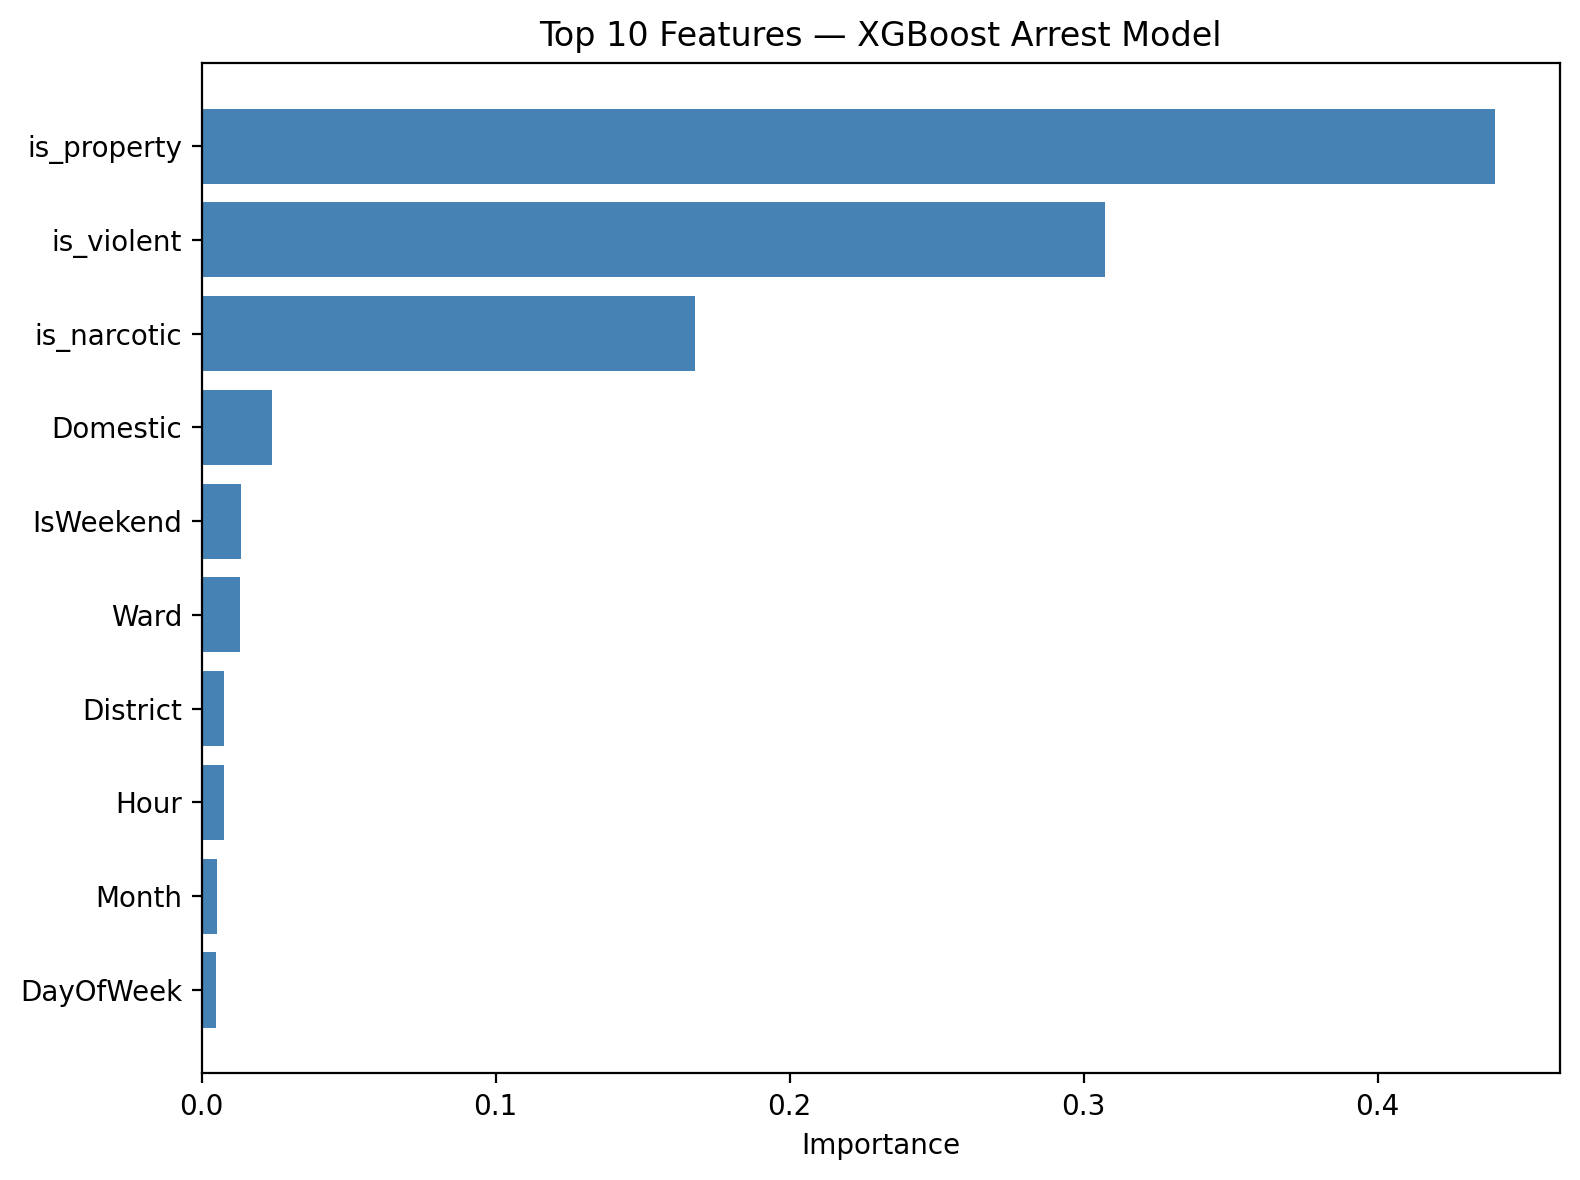


Running SHAP interpretability...


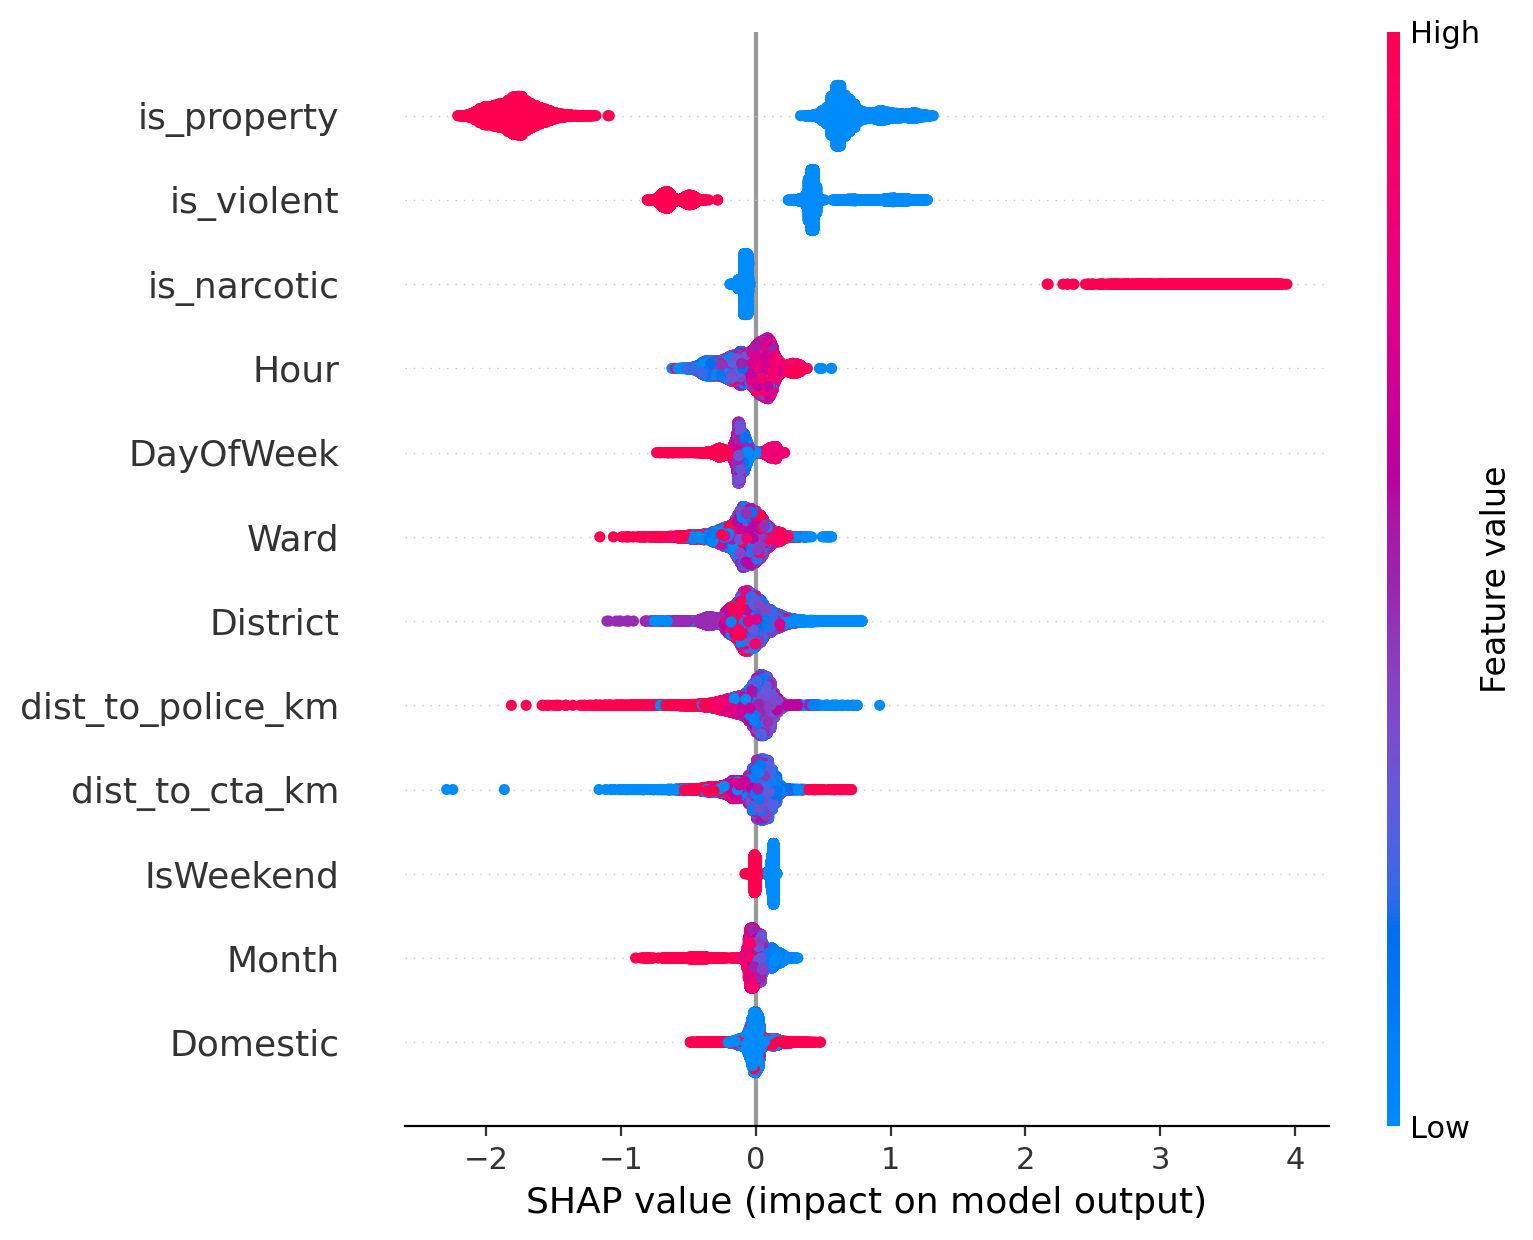

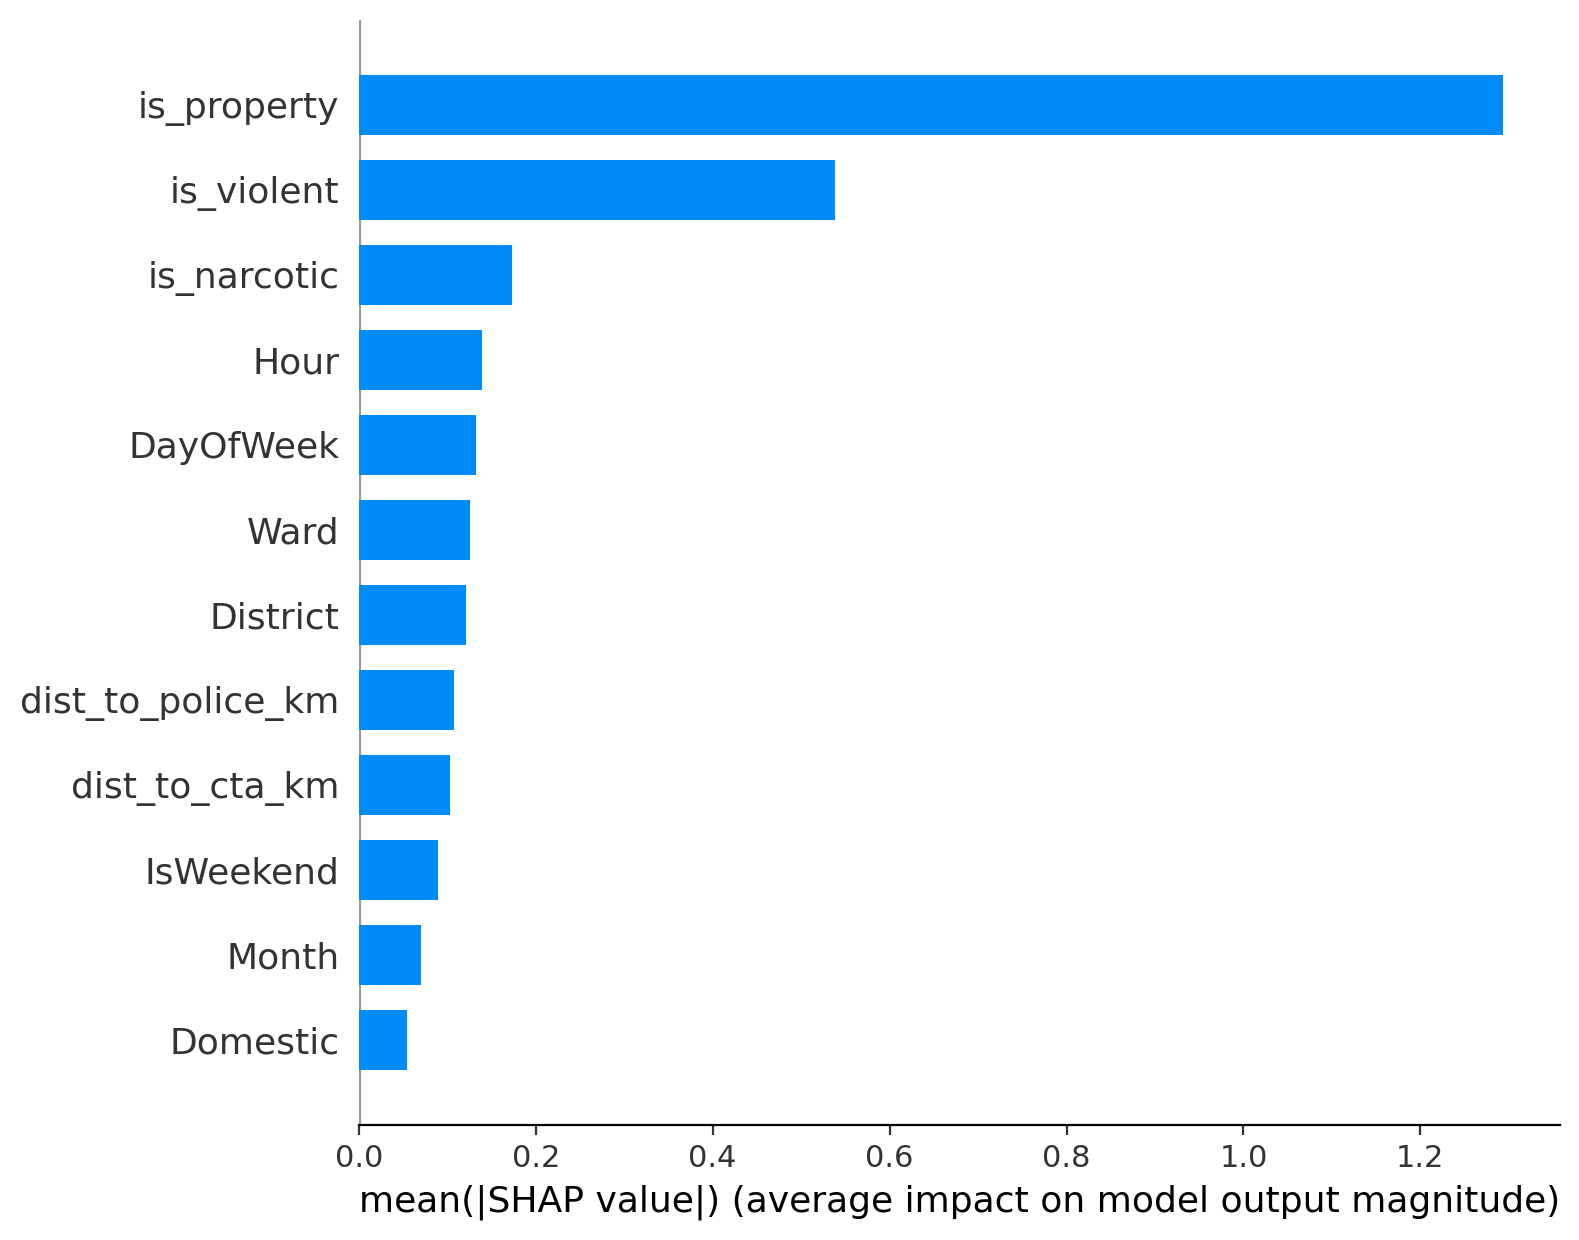

<Figure size 1400x1000 with 0 Axes>

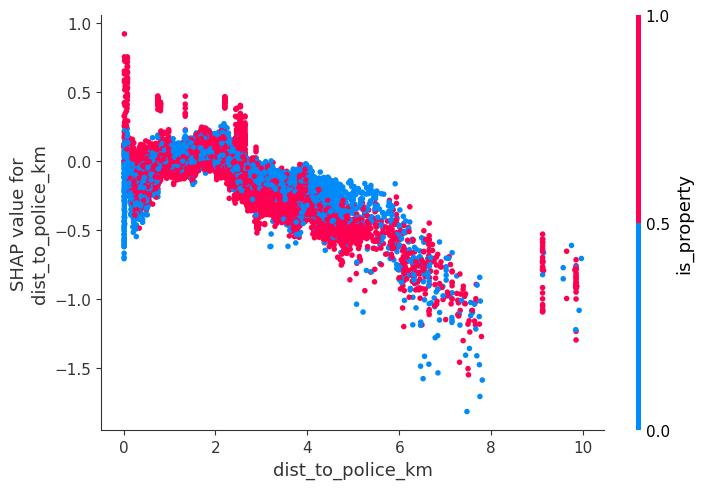

<Figure size 1400x1000 with 0 Axes>

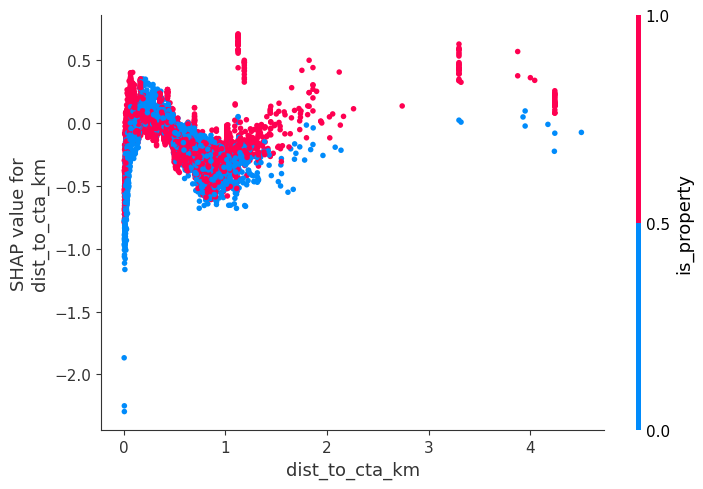


Analyzing relationship between Arrest and distance features...


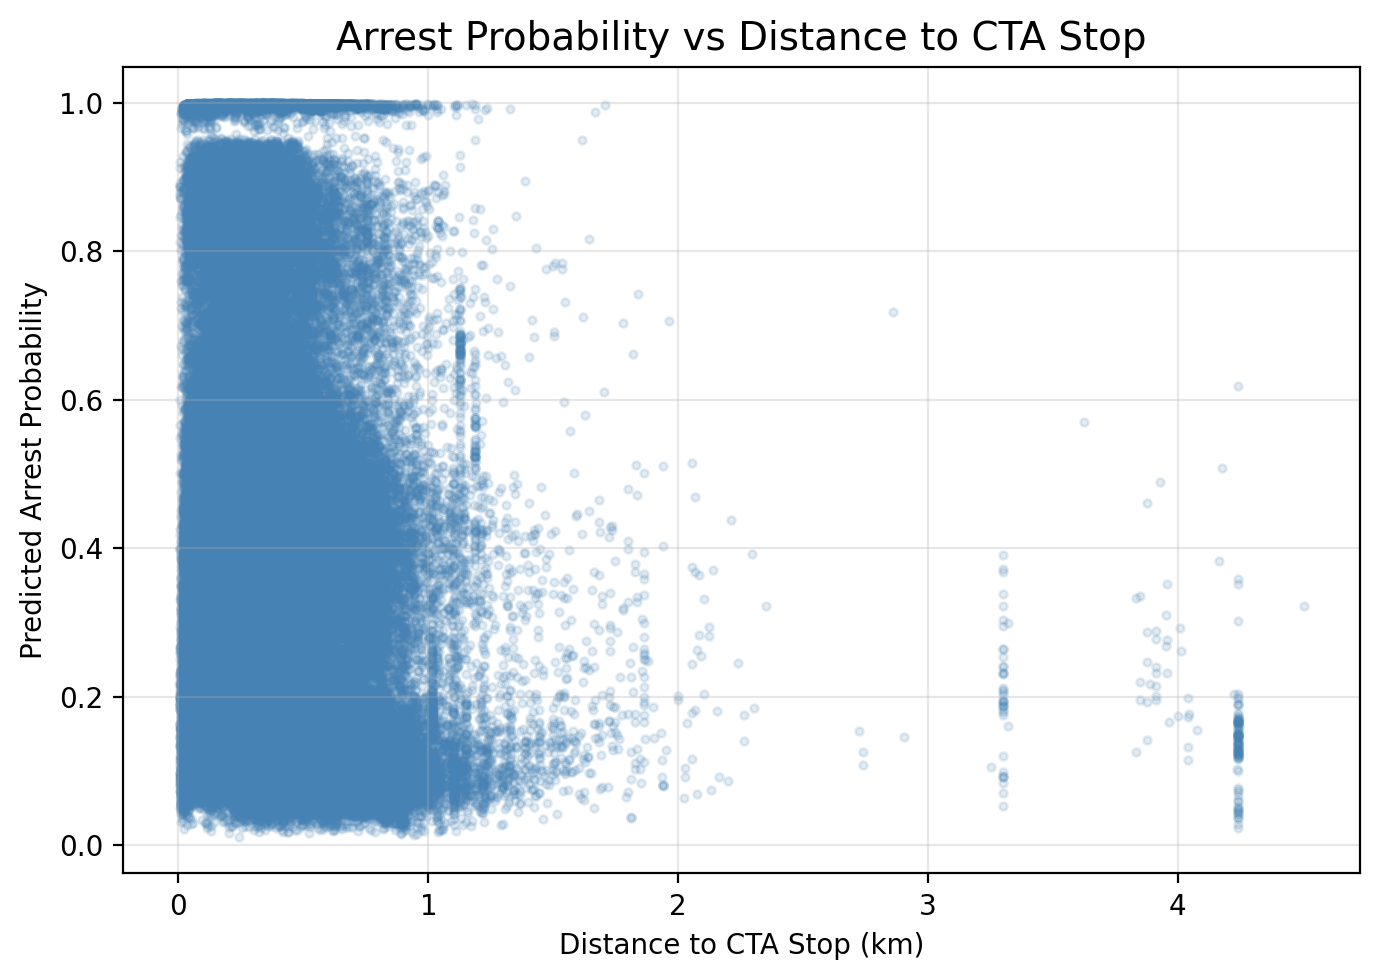

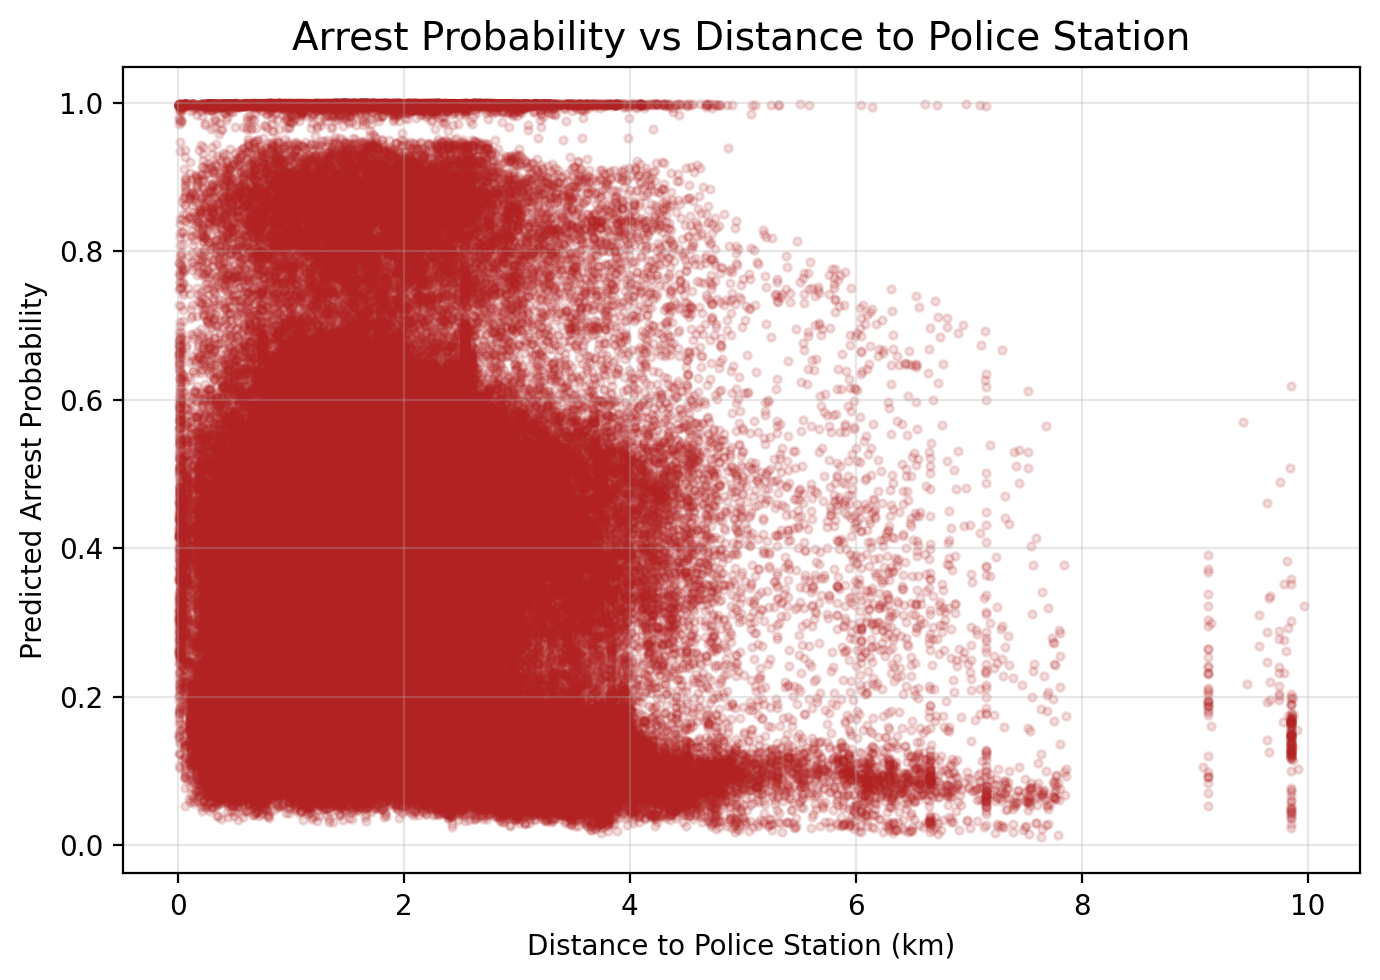


Correlation Results:
  Arrest vs Distance to CTA:    -0.0807
  Arrest vs Distance to Police: -0.0844

Arrest Model (ML MODEL 2) completed with SHAP & distance analysis.



In [82]:
# ==========================================================
# ML MODEL 2 — INCIDENT-LEVEL ARREST PREDICTION (FINAL)
# ==========================================================

import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

import shap

plt.style.use("default")  # Light theme

print("\n==============================")
print("ML MODEL 2 — INCIDENT-LEVEL ARREST PREDICTION (WITH SPATIAL)")
print("==============================\n")

# ----------------------------------------------------------
# 0. Ensure required temporal fields exist
# ----------------------------------------------------------
crime_df['DayOfWeek'] = crime_df['Date'].dt.dayofweek
crime_df['IsWeekend'] = (crime_df['DayOfWeek'] >= 5).astype(int)
crime_df['Month'] = crime_df['Date'].dt.month
crime_df['Hour'] = crime_df['Date'].dt.hour

# ----------------------------------------------------------
# 1. Sampling
# ----------------------------------------------------------
print("Preparing incident-level data...")

sample_size = min(200000, len(crime_df))
crime_sample = crime_df.sample(n=sample_size, random_state=42)

print(f"Sampled {len(crime_sample):,} incidents")

# ----------------------------------------------------------
# 2. Feature construction
# ----------------------------------------------------------
print("\nCreating features...")

features_arrest = [
    'District', 'Ward', 'is_violent', 'is_property', 'is_narcotic',
    'Domestic', 'Month', 'Hour', 'DayOfWeek', 'IsWeekend',
    'dist_to_police_km', 'dist_to_cta_km'
]

X_arrest = crime_sample[features_arrest]
y_arrest = crime_sample['Arrest'].astype(int)

# Temporal split (train ≤ 2023, test ≥ 2024)
train_mask_arrest = crime_sample['Year'] <= 2023
X_train_arrest = X_arrest[train_mask_arrest]
y_train_arrest = y_arrest[train_mask_arrest]
X_test_arrest = X_arrest[~train_mask_arrest]
y_test_arrest = y_arrest[~train_mask_arrest]

print("\nTrain/Test Split:")
print(f"  Training: {len(X_train_arrest):,} incidents ({y_train_arrest.mean()*100:.1f}% arrested)")
print(f"  Test:     {len(X_test_arrest):,} incidents ({y_test_arrest.mean()*100:.1f}% arrested)")

# ----------------------------------------------------------
# 3. Handle class imbalance with SMOTE
# ----------------------------------------------------------
if y_train_arrest.mean() < 0.3:
    print("\nApplying SMOTE...")
    sm = SMOTE(random_state=42)
    X_train_arrest, y_train_arrest = sm.fit_resample(X_train_arrest, y_train_arrest)
    print(f"  After SMOTE: {len(X_train_arrest):,} samples ({y_train_arrest.mean()*100:.1f}% arrested)")

# ----------------------------------------------------------
# 4. Train models
# ----------------------------------------------------------
print("\nTraining Arrest Prediction Models...")

# Logistic Regression
lr_arrest = LogisticRegression(max_iter=1000, random_state=42)
lr_arrest.fit(X_train_arrest, y_train_arrest)
lr_proba = lr_arrest.predict_proba(X_test_arrest)[:, 1]
lr_pred = lr_arrest.predict(X_test_arrest)

# Random Forest
rf_arrest = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42)
rf_arrest.fit(X_train_arrest, y_train_arrest)
rf_proba = rf_arrest.predict_proba(X_test_arrest)[:, 1]
rf_pred = rf_arrest.predict(X_test_arrest)

# XGBoost
xgb_arrest = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb_arrest.fit(X_train_arrest, y_train_arrest)
xgb_proba = xgb_arrest.predict_proba(X_test_arrest)[:, 1]
xgb_pred = xgb_arrest.predict(X_test_arrest)

# ----------------------------------------------------------
# 5. Model Selection (F1 at threshold 0.5)
# ----------------------------------------------------------
print("\nMODEL PERFORMANCE — INCIDENT-LEVEL ARREST PREDICTION:\n")

models = {
    "Logistic Regression": (lr_arrest, lr_pred, lr_proba),
    "Random Forest":       (rf_arrest, rf_pred, rf_proba),
    "XGBoost":             (xgb_arrest, xgb_pred, xgb_proba)
}

best_name, best_model = None, None
best_pred, best_proba = None, None
best_f1 = -1

for name, (model, pred, proba) in models.items():
    f1 = f1_score(y_test_arrest, pred)
    acc = accuracy_score(y_test_arrest, pred)
    prec = precision_score(y_test_arrest, pred, zero_division=0)
    rec = recall_score(y_test_arrest, pred, zero_division=0)

    print(f"{name}:  F1={f1:.3f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_model = model
        best_pred = pred
        best_proba = proba

print(f"\nBest Arrest Model: {best_name} (F1 @ 0.5 = {best_f1:.3f})")

# ----------------------------------------------------------
# 6. F1-optimal threshold
# ----------------------------------------------------------
print("\nFinding optimal threshold for best arrest model...")

thresholds = np.linspace(0, 1, 300)
f1_scores = [f1_score(y_test_arrest, (best_proba >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_threshold = f1_scores[best_idx]

print(f"  Optimal threshold: {best_threshold:.3f}")
print(f"  Best F1 at threshold: {best_f1_threshold:.3f}")

y_pred_opt = (best_proba >= best_threshold).astype(int)

# ----------------------------------------------------------
# 7. Confusion Matrix (Best Model @ Optimal Threshold)
# ----------------------------------------------------------
print("\nPlotting confusion matrix...")

cm = confusion_matrix(y_test_arrest, y_pred_opt)

fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d", ax=ax)
ax.set_title(f"{best_name} — Arrest Model (Threshold={best_threshold:.2f})")
plt.tight_layout()
plt.savefig("arrest_confusion_matrix.png", dpi=300)
plt.show()

# ----------------------------------------------------------
# 8. ROC Curve (Best Arrest Model)
# ----------------------------------------------------------
print("\nPlotting ROC curve...")

fpr, tpr, _ = roc_curve(y_test_arrest, best_proba)
auc = roc_auc_score(y_test_arrest, best_proba)

plt.figure(figsize=(7, 6), dpi=200)
plt.plot(fpr, tpr, color="darkblue", linewidth=2.5, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.title(f"ROC Curve — {best_name} Arrest Model", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("arrest_roc_curve.png", dpi=300)
plt.show()

# ----------------------------------------------------------
# 9. FULL Feature Importance (Tree Models Only)
# ----------------------------------------------------------
if best_name in ["Random Forest", "XGBoost"]:
    print("\nComputing full feature importance table...")

    importances = best_model.feature_importances_
    full_imp_df = pd.DataFrame({
        "Feature": features_arrest,
        "Importance": importances
    }).sort_values("Importance", ascending=False)

    print("\n==============================")
    print("FULL FEATURE IMPORTANCE TABLE")
    print("==============================")
    print(full_imp_df.to_string(index=False))

    full_imp_df.to_csv("arrest_feature_importance_full.csv", index=False)

    # Top 10 bar plot
    top_n = 10
    top_df = full_imp_df.head(top_n)

    plt.figure(figsize=(8, 6), dpi=200)
    plt.barh(top_df["Feature"][::-1], top_df["Importance"][::-1], color="steelblue")
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Features — {best_name} Arrest Model")
    plt.tight_layout()
    plt.savefig("arrest_feature_importance_top10.png", dpi=300)
    plt.show()
else:
    print("\nFeature importance not supported for Logistic Regression. Skipping importance table.")

# ----------------------------------------------------------
# 10. SHAP Interpretability (Tree Models Only)
# ----------------------------------------------------------
print("\nRunning SHAP interpretability...")

explainer = None
if best_name in ["Random Forest", "XGBoost"]:
    explainer = shap.TreeExplainer(best_model)
else:
    print("SHAP only enabled for tree-based models (RF/XGBoost). Skipping SHAP.")

if explainer is not None:
    # SHAP values (handle list vs array)
    shap_vals_raw = explainer.shap_values(X_test_arrest)
    if isinstance(shap_vals_raw, list):
        shap_values = shap_vals_raw[1] if len(shap_vals_raw) > 1 else shap_vals_raw[0]
    else:
        shap_values = shap_vals_raw

    # Global summary
    plt.figure(figsize=(10, 6), dpi=200)
    shap.summary_plot(shap_values, X_test_arrest, show=False)
    plt.tight_layout()
    plt.savefig("arrest_shap_summary.png", dpi=300)
    plt.show()

    # Bar summary
    plt.figure(figsize=(10, 6), dpi=200)
    shap.summary_plot(shap_values, X_test_arrest, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("arrest_shap_bar.png", dpi=300)
    plt.show()

    # SHAP dependence plots for spatial features
    for feature in ["dist_to_police_km", "dist_to_cta_km"]:
        plt.figure(figsize=(7, 5), dpi=200)
        shap.dependence_plot(feature, shap_values, X_test_arrest, show=False)
        plt.tight_layout()
        plt.savefig(f"arrest_shap_dependence_{feature}.png", dpi=300)
        plt.show()

# ----------------------------------------------------------
# 11. Relationship: Arrest Probability vs Distance Features
# ----------------------------------------------------------
print("\nAnalyzing relationship between Arrest and distance features...")

# Predicted probabilities for the full sample
crime_sample["arrest_proba"] = best_model.predict_proba(X_arrest)[:, 1]

# 1. Distance to CTA stop
plt.figure(figsize=(7, 5), dpi=200)
plt.scatter(
    crime_sample["dist_to_cta_km"],
    crime_sample["arrest_proba"],
    alpha=0.15, s=8, color="steelblue"
)
plt.title("Arrest Probability vs Distance to CTA Stop", fontsize=14)
plt.xlabel("Distance to CTA Stop (km)")
plt.ylabel("Predicted Arrest Probability")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("arrest_vs_cta_distance.png", dpi=300)
plt.show()

# 2. Distance to Police Station
plt.figure(figsize=(7, 5), dpi=200)
plt.scatter(
    crime_sample["dist_to_police_km"],
    crime_sample["arrest_proba"],
    alpha=0.15, s=8, color="firebrick"
)
plt.title("Arrest Probability vs Distance to Police Station", fontsize=14)
plt.xlabel("Distance to Police Station (km)")
plt.ylabel("Predicted Arrest Probability")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("arrest_vs_police_distance.png", dpi=300)
plt.show()

# 3. Correlations
cta_corr = crime_sample["arrest_proba"].corr(crime_sample["dist_to_cta_km"])
police_corr = crime_sample["arrest_proba"].corr(crime_sample["dist_to_police_km"])

print("\nCorrelation Results:")
print(f"  Arrest vs Distance to CTA:    {cta_corr:.4f}")
print(f"  Arrest vs Distance to Police: {police_corr:.4f}")

print("\nArrest Model (ML MODEL 2) completed with SHAP & distance analysis.\n")



[8] Geospatial Hotspot Modeling (KDE + DBSCAN)


FileNotFoundError: [Errno 2] No such file or directory: 'visualizations/kde_violent_hotspots.png'

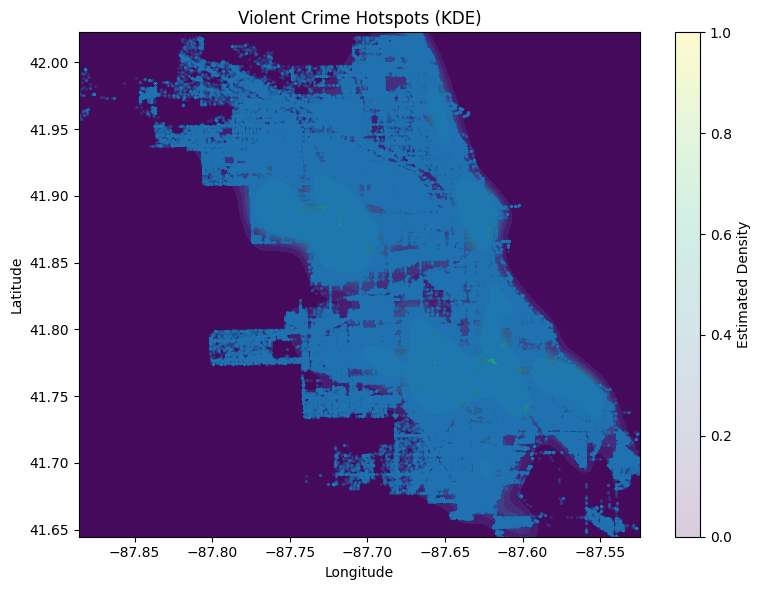

In [84]:
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

print("\n[8] Geospatial Hotspot Modeling (KDE + DBSCAN)")

# Filter violent crimes with valid coordinates
violent_coords = crime_df[
    (crime_df['is_violent'] == 1) &
    crime_df['Latitude'].notna() &
    crime_df['Longitude'].notna()
][['Longitude', 'Latitude']]

if len(violent_coords) > 0:
    # KDE requires shape (n_features, n_samples)
    coords = violent_coords.to_numpy().T  # (2, N)

    kde = gaussian_kde(coords)

    # Grid over the crime area
    lon_min, lon_max = violent_coords['Longitude'].min(), violent_coords['Longitude'].max()
    lat_min, lat_max = violent_coords['Latitude'].min(), violent_coords['Latitude'].max()

    grid_lon = np.linspace(lon_min, lon_max, 100)
    grid_lat = np.linspace(lat_min, lat_max, 100)
    grid_lon_m, grid_lat_m = np.meshgrid(grid_lon, grid_lat)
    grid_coords = np.vstack([grid_lon_m.ravel(), grid_lat_m.ravel()])

    density = kde(grid_coords)
    density_grid = density.reshape(grid_lat_m.shape)

    # Plot KDE hotspots
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_lon_m, grid_lat_m, density_grid, levels=20)
    plt.scatter(
        violent_coords['Longitude'], violent_coords['Latitude'],
        s=2, alpha=0.2
    )
    plt.title("Violent Crime Hotspots (KDE)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Estimated Density")
    plt.tight_layout()
    plt.savefig("visualizations/kde_violent_hotspots.png", dpi=300)
    plt.close()
    print("Saved KDE hotspot map to visualizations/kde_violent_hotspots.png")

    # OPTIONAL: DBSCAN clustering for crime clusters
    dbscan = DBSCAN(eps=0.01, min_samples=30)  # tune eps/min_samples as needed
    labels = dbscan.fit_predict(violent_coords[['Longitude', 'Latitude']])

    violent_coords_clustered = violent_coords.copy()
    violent_coords_clustered['cluster'] = labels

    # Plot clusters (ignore noise label = -1)
    plt.figure(figsize=(8, 6))
    clustered = violent_coords_clustered[violent_coords_clustered['cluster'] != -1]
    scatter = plt.scatter(
        clustered['Longitude'], clustered['Latitude'],
        c=clustered['cluster'], s=5
    )
    plt.title("Violent Crime Clusters (DBSCAN)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig("dbscan_violent_clusters.png", dpi=300)
    plt.close()
    print("Saved DBSCAN cluster map to visualizations/dbscan_violent_clusters.png")

else:
    print("No violent coordinates available for KDE/DBSCAN.")